# Experimentos con StyleGAN para Generación de Pixel Art

## 1. Setup

Instalación de librerías, importaciones necesarias y configuración del dispositivo de cómputo (GPU/CPU).

In [1]:
!pip install torch torchvision tqdm torch-fidelity --quiet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from tqdm import tqdm
import math
from typing import Optional, Tuple
import random
import kagglehub
from torch_fidelity import calculate_metrics
import pandas as pd

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Crear directorios para resultados
os.makedirs('results', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

Usando dispositivo: cuda


## 2. Datos

Carga y preparación del dataset de Pixel Art. El dataset utilizado es [Pixel Art Sprites](https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art) de Kaggle.

In [4]:
ebrahimelgazar_pixel_art_path = kagglehub.dataset_download('ebrahimelgazar/pixel-art')
DATA_PATH = os.path.join(ebrahimelgazar_pixel_art_path, 'sprites.npy')
print(f'Ruta del dataset: {DATA_PATH}')

Ruta del dataset: /kaggle/input/pixel-art/sprites.npy


In [5]:
class PixelArtDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.sprites = np.load(data_path)
        self.transform = transform

    def __len__(self):
        return len(self.sprites)

    def __getitem__(self, idx):
        image = self.sprites[idx]
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image

## 3. Preprocesamiento

Normalización de las imágenes y visualización de una muestra del dataset.

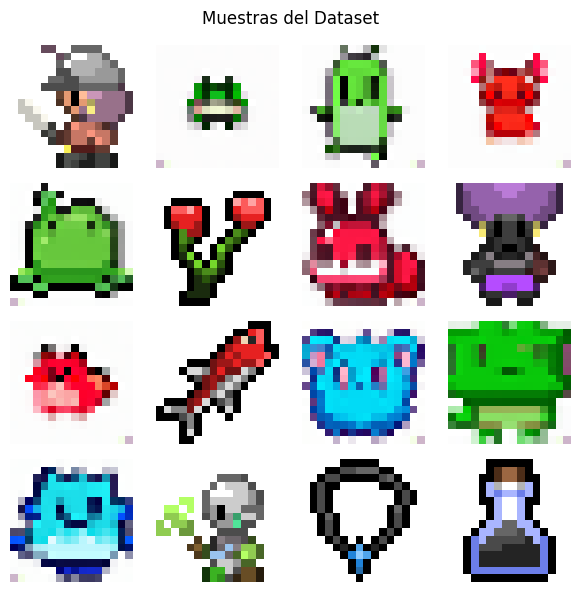

In [6]:
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = PixelArtDataset(DATA_PATH, transform=transform)

def denormalize(tensor):
    return (tensor * 0.5) + 0.5

sample_loader = DataLoader(dataset, batch_size=16, shuffle=True)
sample_images = next(iter(sample_loader))
sample_images_denorm = denormalize(sample_images)

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img = sample_images_denorm[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Muestras del Dataset')
plt.tight_layout()
plt.savefig('results/dataset_samples.png')
plt.show()

In [7]:
REAL_STATS_PATH = 'results/real_pixelart_stats.npz'

if not os.path.exists(REAL_STATS_PATH):
    print("Calculating real dataset statistics for FID/IS...")

    # This dataset returns unnormalized (0-255) images as torch.Tensors with shape (C, H, W)
    class UnnormalizedPixelArtDataset(Dataset):
        def __init__(self, data_path):
            self.sprites = np.load(data_path)
        def __len__(self):
            return len(self.sprites)
        def __getitem__(self, idx):
            image = self.sprites[idx]
            # Convert to tensor and permute from (H, W, C) to (C, H, W)
            return torch.from_numpy(image).permute(2, 0, 1)

    unnormalized_dataset = UnnormalizedPixelArtDataset(DATA_PATH)
    # Use a subset for faster computation in this demo environment
    subset_indices = np.random.choice(len(unnormalized_dataset), 5000, replace=False)
    subset_dataset = torch.utils.data.Subset(unnormalized_dataset, subset_indices)

    # By asking for a metric that only requires one input (like ISC) and providing caching arguments,
    # torch-fidelity will compute the necessary features (which are the same for FID) and save them.
    calculate_metrics(
        input1=subset_dataset,
        isc=True,
        input1_cache_name=os.path.basename(REAL_STATS_PATH).replace('.npz',''),
        input1_cache_root=os.path.dirname(REAL_STATS_PATH),
        verbose=False
    )
    print(f"Real dataset statistics saved to {REAL_STATS_PATH}")
else:
    print(f"Real dataset statistics already exist at {REAL_STATS_PATH}")

Calculating real dataset statistics for FID/IS...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 75.1MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Real dataset statistics saved to results/real_pixelart_stats.npz


## 4. Entrenamiento A/B/C

En esta sección se definen los componentes de la GAN y las tres configuraciones de entrenamiento.

### Componentes del Modelo (StyleGAN)

In [8]:
class EqualizedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, lr_multiplier=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.lr_multiplier = lr_multiplier
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        self.weight_scale = lr_multiplier / math.sqrt(in_features)

    def forward(self, x):
        weight = self.weight * self.weight_scale
        bias = self.bias * self.lr_multiplier if self.bias is not None else None
        return F.linear(x, weight, bias)

class EqualizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)
        self.weight_scale = 1 / math.sqrt(in_channels * kernel_size * kernel_size)

    def forward(self, x):
        weight = self.weight * self.weight_scale
        return F.conv2d(x, weight, self.bias, self.stride, self.padding)

class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=256, hidden_dim=256, num_layers=4):
        super().__init__()
        layers = []
        for i in range(num_layers):
            in_dim = latent_dim if i == 0 else hidden_dim
            layers.extend([EqualizedLinear(in_dim, hidden_dim), nn.LeakyReLU(0.2)])
        self.network = nn.Sequential(*layers)

    def forward(self, z):
        return self.network(z)

class AdaIN(nn.Module):
    def __init__(self, num_features, style_dim):
        super().__init__()
        self.norm = nn.LayerNorm(num_features)
        self.style_scale = EqualizedLinear(style_dim, num_features)
        self.style_bias = EqualizedLinear(style_dim, num_features)

    def forward(self, x, style):
        N, C, H, W = x.shape
        x = x.view(N, C, H * W).permute(0, 2, 1)
        normalized = self.norm(x)
        normalized = normalized.permute(0, 2, 1).view(N, C, H, W)
        scale = self.style_scale(style).unsqueeze(2).unsqueeze(3)
        bias = self.style_bias(style).unsqueeze(2).unsqueeze(3)
        return normalized * (1 + scale) + bias

class SynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, style_dim, upsample=True):
        super().__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv1 = EqualizedConv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = EqualizedConv2d(out_channels, out_channels, 3, padding=1)
        self.adain1 = AdaIN(out_channels, style_dim)
        self.adain2 = AdaIN(out_channels, style_dim)
        self.noise1 = nn.Parameter(torch.zeros(1, out_channels, 1, 1))
        self.noise2 = nn.Parameter(torch.zeros(1, out_channels, 1, 1))

    def forward(self, x, style):
        if self.upsample:
            x = self.upsample_layer(x)
        x = self.conv1(x)
        x = x + self.noise1 * torch.randn_like(x)
        x = F.leaky_relu(x, 0.2)
        x = self.adain1(x, style)
        x = self.conv2(x)
        x = x + self.noise2 * torch.randn_like(x)
        x = F.leaky_relu(x, 0.2)
        x = self.adain2(x, style)
        return x

class Generator(nn.Module):
    def __init__(self, latent_dim=256, style_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        self.style_dim = style_dim
        self.mapping = MappingNetwork(latent_dim, style_dim, num_layers=4)
        self.constant = nn.Parameter(torch.randn(1, 256, 4, 4))
        self.blocks = nn.ModuleList([
            SynthesisBlock(256, 128, style_dim, upsample=True),
            SynthesisBlock(128, 64, style_dim, upsample=True)
        ])
        self.to_rgb = EqualizedConv2d(64, 3, 1)

    def forward(self, z, truncation_psi=1.0):
        batch_size = z.size(0)
        w = self.mapping(z)
        if truncation_psi < 1.0:
            w_avg = w.mean(dim=0, keepdim=True)
            w = w_avg + truncation_psi * (w - w_avg)
        x = self.constant.repeat(batch_size, 1, 1, 1)
        for block in self.blocks:
            x = block(x, w)
        x = self.to_rgb(x)
        x = torch.tanh(x)
        return x

class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims, mean=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dims = kernel_dims
        self.mean = mean
        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dims))

    def forward(self, x):
        matrices = x.mm(self.T.view(self.in_features, -1))
        matrices = matrices.view(-1, self.out_features, self.kernel_dims)
        M = matrices.unsqueeze(0)
        M_T = M.permute(1, 0, 2, 3)
        c = torch.abs(M - M_T).sum(3)
        c = torch.exp(-c)
        o = c.sum(0)
        if self.mean:
            o /= x.size(0)
        return torch.cat([x, o], 1)

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, dropout_rate=0.4):
        super().__init__()
        self.downsample = downsample
        self.conv1 = EqualizedConv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = EqualizedConv2d(out_channels, out_channels, 3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)
        if downsample:
            self.downsample_layer = nn.AvgPool2d(2)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.dropout(x)
        if self.downsample:
            x = self.downsample_layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        self.from_rgb = EqualizedConv2d(3, 64, 1)
        self.blocks = nn.ModuleList([
            DiscriminatorBlock(64, 128, downsample=True, dropout_rate=dropout_rate),
            DiscriminatorBlock(128, 256, downsample=True, dropout_rate=dropout_rate),
        ])
        in_features = 256 * 4 * 4
        self.minibatch_discrimination = MinibatchDiscrimination(in_features, 128, 16)
        self.final_linear = EqualizedLinear(in_features + 128, 1)

    def forward(self, x):
        x = F.leaky_relu(self.from_rgb(x), 0.2)
        for block in self.blocks:
            x = block(x)
        features = F.leaky_relu(x, 0.2)
        x = features.reshape(x.size(0), -1)
        x = self.minibatch_discrimination(x)
        x = self.final_linear(x)
        return x, features

# --- Adaptive Discriminator Augmentation (ADA) ---
def rand_translation(x, ratio=0.125):
    n, c, h, w = x.shape
    shift_x = torch.randint(-int(w * ratio), int(w * ratio) + 1, (n, 1, 1), device=x.device)
    shift_y = torch.randint(-int(h * ratio), int(h * ratio) + 1, (n, 1, 1), device=x.device)
    grid = torch.meshgrid(torch.arange(h, device=x.device), torch.arange(w, device=x.device), indexing='ij')
    grid_x = grid[1].unsqueeze(0).repeat(n, 1, 1) + shift_x
    grid_y = grid[0].unsqueeze(0).repeat(n, 1, 1) + shift_y
    grid_x = 2 * grid_x / (w - 1) - 1
    grid_y = 2 * grid_y / (h - 1) - 1
    grid = torch.stack((grid_x, grid_y), dim=3)
    return F.grid_sample(x, grid, padding_mode='reflection', align_corners=False)

def rand_cutout(x, ratio=0.5):
    n, c, h, w = x.shape
    cutout_size_h = torch.randint(1, int(h * ratio) + 1, (1,)).item()
    cutout_size_w = torch.randint(1, int(w * ratio) + 1, (1,)).item()
    offset_x = torch.randint(0, w - cutout_size_w + 1, (1,)).item()
    offset_y = torch.randint(0, h - cutout_size_h + 1, (1,)).item()
    x_cutout = x.clone()
    x_cutout[:, :, offset_y:offset_y+cutout_size_h, offset_x:offset_x+cutout_size_w] = 0
    return x_cutout

class AdaptiveAugmenter:
    def __init__(self, target_rt, p_init=0.0, speed=0.01, freq=4):
        self.target_rt = target_rt
        self.p = p_init
        self.speed = speed
        self.freq = freq
        self.n_minibatches = 0
        self.rt_history = []
        self.augmentations = [('translation', rand_translation), ('cutout', rand_cutout)]

    def __call__(self, images):
        if self.p == 0:
            return images

        augmented_images = []
        for i in range(images.size(0)):
            if random.random() < self.p:
                img = images[i].unsqueeze(0)
                aug_fn = random.choice(self.augmentations)[1]
                augmented_images.append(aug_fn(img).squeeze(0))
            else:
                augmented_images.append(images[i])
        return torch.stack(augmented_images)

    def update(self, real_output):
        rt = torch.sign(real_output).mean().item()
        self.rt_history.append(rt)
        self.n_minibatches += 1

        if self.n_minibatches % self.freq == 0:
            avg_rt = np.mean(self.rt_history)
            if avg_rt > self.target_rt:
                self.p += self.speed
            else:
                self.p -= self.speed
            self.p = np.clip(self.p, 0.0, 0.8) # Clip p to avoid extreme values
            self.rt_history = []
        return self.p, rt

# --- Config 3 Components: ResNet Discriminator and R1 Penalty ---
class ResDiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True):
        super().__init__()
        self.downsample = downsample

        self.conv1 = EqualizedConv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = EqualizedConv2d(out_channels, out_channels, 3, padding=1)

        self.skip_conv = None
        if in_channels != out_channels or downsample:
            self.skip_conv = EqualizedConv2d(in_channels, out_channels, 1, bias=False)

        if downsample:
            self.downsample_layer = nn.AvgPool2d(2)

    def forward(self, x):
        identity = x

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.conv2(out)

        if self.downsample:
            out = self.downsample_layer(out)
            identity = self.downsample_layer(identity)

        if self.skip_conv:
            identity = self.skip_conv(identity)

        return (out + identity) / math.sqrt(2)

class ResDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.from_rgb = EqualizedConv2d(3, 64, 1)
        self.blocks = nn.ModuleList([
            ResDiscriminatorBlock(64, 128, downsample=True),
            ResDiscriminatorBlock(128, 256, downsample=True),
            ResDiscriminatorBlock(256, 256, downsample=False),
        ])
        in_features = 256 * 4 * 4
        self.final_linear = EqualizedLinear(in_features, 1)

    def forward(self, x):
        x = F.leaky_relu(self.from_rgb(x), 0.2)
        for block in self.blocks:
            x = block(x)
        features = F.leaky_relu(x, 0.2)
        x = features.reshape(x.size(0), -1)
        x = self.final_linear(x)
        return x, features

def r1_penalty(real_images, discriminator, gamma=10):
    real_images.requires_grad = True
    real_output, _ = discriminator(real_images)
    grad_real = torch.autograd.grad(outputs=real_output.sum(), inputs=real_images, create_graph=True)[0]
    grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
    grad_penalty = (gamma / 2) * grad_penalty
    real_images.requires_grad = False
    return grad_penalty

### Funciones de Utilidad para Entrenamiento

In [9]:
def save_samples(generator, name, fixed_z, num_samples=64):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_z)
        fake_images = denormalize(fake_images)

        rows = int(np.sqrt(num_samples))
        cols = int(np.ceil(num_samples / rows))

        fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            if i < num_samples:
                img = fake_images[i].cpu().permute(1, 2, 0).numpy()
                ax.imshow(img)
            ax.axis('off')

        plt.suptitle(f'Generated Images: {name}')
        os.makedirs('results/inference', exist_ok=True)
        plt.savefig(f'results/inference/{name}.png', dpi=150)
        plt.show()
    generator.train()

### 4.1. Configuración 1: Baseline

La configuración original, que servirá como nuestra línea de base para la comparación.

In [10]:
def train_baseline(config, dataloader):
    # Hyperparameters
    NUM_EPOCHS = config['num_epochs']
    LATENT_DIM = config['latent_dim']

    # Models
    generator = Generator(latent_dim=LATENT_DIM).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=config['lr_g'], betas=(config['beta1'], config['beta2']))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=(config['beta1'], config['beta2']))

    criterion = nn.BCEWithLogitsLoss()

    losses_G, losses_D = [], []
    fixed_z = torch.randn(64, LATENT_DIM, device=device)

    print("--- Iniciando Entrenamiento: Baseline ---")
    for epoch in range(NUM_EPOCHS):
        epoch_loss_G, epoch_loss_D = 0, 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

        for i, real_images in enumerate(progress_bar):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_output, _ = discriminator(real_images)
            d_loss_real = criterion(real_output, real_labels)
            z = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_images = generator(z)
            fake_output, _ = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_output, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            fake_output, fake_features = discriminator(fake_images)
            _, real_features = discriminator(real_images)
            g_loss_adv = criterion(fake_output, real_labels)
            g_loss_fm = F.l1_loss(fake_features.mean(0), real_features.mean(0).detach())
            g_loss = g_loss_adv + g_loss_fm
            g_loss.backward()
            optimizer_G.step()

            epoch_loss_G += g_loss.item()
            epoch_loss_D += d_loss.item()
            progress_bar.set_postfix({'D_loss': f'{d_loss.item():.4f}', 'G_loss': f'{g_loss.item():.4f}'})

        avg_loss_G = epoch_loss_G / len(dataloader)
        avg_loss_D = epoch_loss_D / len(dataloader)
        losses_G.append(avg_loss_G)
        losses_D.append(avg_loss_D)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] - D_loss: {avg_loss_D:.4f}, G_loss: {avg_loss_G:.4f}')

        # Save samples
        if epoch == 0 or epoch == (config['num_epochs'] // 2) or (epoch + 1) == config['num_epochs']:
            save_samples(generator, f'baseline_epoch_{epoch+1}', fixed_z)

    print("--- Entrenamiento Baseline Finalizado ---")
    return generator, discriminator, {'G': losses_G, 'D': losses_D}

### 4.2. Configuración 2: Regularización y Augmentations

Esta configuración introduce dos cambios clave para mejorar la robustez del entrenamiento, especialmente en datasets pequeños: **Adaptive Discriminator Augmentation (ADA)** y un **dropout ligero** en el discriminador.

In [11]:
def train_config_2(config, dataloader):
    # Hyperparameters
    NUM_EPOCHS = config['num_epochs']
    LATENT_DIM = config['latent_dim']
    DROPOUT_RATE = config['dropout_rate']

    # Models
    generator = Generator(latent_dim=LATENT_DIM).to(device)
    discriminator = Discriminator(dropout_rate=DROPOUT_RATE).to(device)

    # Augmenter
    augmenter = AdaptiveAugmenter(target_rt=0.6, speed=0.01)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=config['lr_g'], betas=(config['beta1'], config['beta2']))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=(config['beta1'], config['beta2']))

    criterion = nn.BCEWithLogitsLoss()

    losses_G, losses_D, p_history = [], [], []
    fixed_z = torch.randn(64, LATENT_DIM, device=device)

    print("--- Iniciando Entrenamiento: Configuración 2 (ADA + Dropout) ---")
    for epoch in range(NUM_EPOCHS):
        epoch_loss_G, epoch_loss_D = 0, 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

        for i, real_images in enumerate(progress_bar):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = torch.full((batch_size, 1), 1.0, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # --- Train Discriminator ---
            optimizer_D.zero_grad()

            real_images_aug = augmenter(real_images)
            real_output, _ = discriminator(real_images_aug)
            d_loss_real = criterion(real_output, real_labels)

            p_val, rt_val = augmenter.update(real_output.detach())

            z = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_images = generator(z)
            fake_images_aug = augmenter(fake_images.detach())
            fake_output, _ = discriminator(fake_images_aug)
            d_loss_fake = criterion(fake_output, fake_labels)

            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()

            # --- Train Generator ---
            optimizer_G.zero_grad()
            fake_output_for_g, _ = discriminator(fake_images)
            g_loss = criterion(fake_output_for_g, real_labels)
            g_loss.backward()
            optimizer_G.step()

            epoch_loss_G += g_loss.item()
            epoch_loss_D += d_loss.item()
            p_history.append(p_val)
            progress_bar.set_postfix({'D_loss': f'{d_loss.item():.4f}', 'G_loss': f'{g_loss.item():.4f}', 'p': f'{p_val:.3f}', 'rt': f'{rt_val:.3f}'})

        avg_loss_G = epoch_loss_G / len(dataloader)
        avg_loss_D = epoch_loss_D / len(dataloader)
        losses_G.append(avg_loss_G)
        losses_D.append(avg_loss_D)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] - D_loss: {avg_loss_D:.4f}, G_loss: {avg_loss_G:.4f}, p: {np.mean(p_history[-len(dataloader):]):.3f}')

        if epoch == 0 or epoch == (config['num_epochs'] // 2) or (epoch + 1) == config['num_epochs']:
            save_samples(generator, f'config2_epoch_{epoch+1}', fixed_z)

    print("--- Entrenamiento Configuración 2 Finalizado ---")
    return generator, discriminator, {'G': losses_G, 'D': losses_D, 'p': p_history}


### 4.3. Configuración 3: Variación Arquitectónica / Pérdida

Esta configuración prueba cambios más profundos: una **arquitectura de discriminador residual (ResNet-style)**, una función de **pérdida Hinge**, y la **regularización R1** aplicada de forma intermitente. También se reduce la dimensionalidad del espacio latente.

In [12]:
def train_config_3(config, dataloader):
    # Hyperparameters
    NUM_EPOCHS = config['num_epochs']
    LATENT_DIM = config['latent_dim']
    R1_INTERVAL = config['r1_interval']
    GAMMA = config['r1_gamma']

    # Models
    generator = Generator(latent_dim=LATENT_DIM).to(device)
    discriminator = ResDiscriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=config['lr_g'], betas=(config['beta1'], config['beta2']))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=(config['beta1'], config['beta2']))

    losses_G, losses_D = [], []
    fixed_z = torch.randn(64, LATENT_DIM, device=device)

    print("--- Iniciando Entrenamiento: Configuración 3 (Hinge Loss + ResNet-D + R1) ---")
    for epoch in range(NUM_EPOCHS):
        epoch_loss_G, epoch_loss_D = 0, 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

        for i, real_images in enumerate(progress_bar):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # --- Train Discriminator ---
            optimizer_D.zero_grad()

            real_output, _ = discriminator(real_images)
            d_loss_real = F.relu(1.0 - real_output).mean()

            z = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_images = generator(z)
            fake_output, _ = discriminator(fake_images.detach())
            d_loss_fake = F.relu(1.0 + fake_output).mean()

            d_loss = d_loss_real + d_loss_fake

            if (i + 1) % R1_INTERVAL == 0:
                r1_pen = r1_penalty(real_images, discriminator, gamma=GAMMA)
                d_loss += r1_pen
            else:
                r1_pen = torch.tensor(0.0)

            d_loss.backward()
            optimizer_D.step()

            # --- Train Generator ---
            optimizer_G.zero_grad()
            fake_output_for_g, _ = discriminator(fake_images)
            g_loss = -fake_output_for_g.mean()
            g_loss.backward()
            optimizer_G.step()

            epoch_loss_G += g_loss.item()
            epoch_loss_D += d_loss.item()
            progress_bar.set_postfix({'D_loss': f'{d_loss.item():.4f}', 'G_loss': f'{g_loss.item():.4f}', 'R1': f'{r1_pen.item():.2f}'})

        avg_loss_G = epoch_loss_G / len(dataloader)
        avg_loss_D = epoch_loss_D / len(dataloader)
        losses_G.append(avg_loss_G)
        losses_D.append(avg_loss_D)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] - D_loss: {avg_loss_D:.4f}, G_loss: {avg_loss_G:.4f}')

        if epoch == 0 or epoch == (config['num_epochs'] // 2) or (epoch + 1) == config['num_epochs']:
            save_samples(generator, f'config3_epoch_{epoch+1}', fixed_z)

    print("--- Entrenamiento Configuración 3 Finalizado ---")
    return generator, discriminator, {'G': losses_G, 'D': losses_D}


### Ejecución del Entrenamiento

--- Iniciando Entrenamiento: Baseline ---


Epoch 1/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.5882, G_loss=1.4668]


Epoch [1/50] - D_loss: 0.6160, G_loss: 1.1364


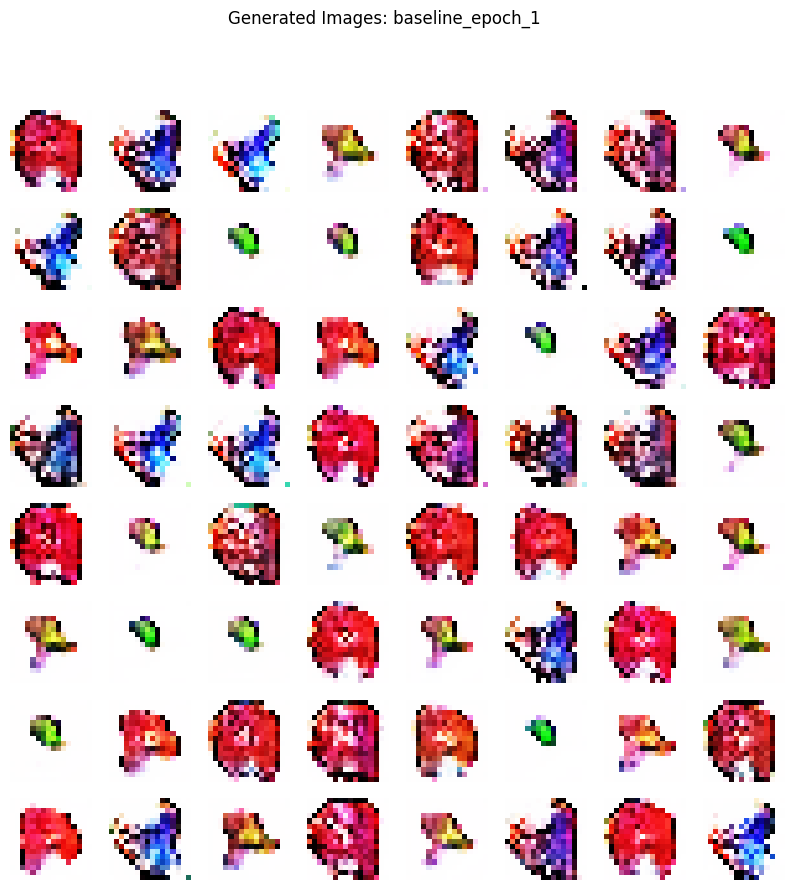

Epoch 2/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.5034, G_loss=1.5455]


Epoch [2/50] - D_loss: 0.5455, G_loss: 1.3734


Epoch 3/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.85it/s, D_loss=0.6163, G_loss=1.0326]


Epoch [3/50] - D_loss: 0.5010, G_loss: 1.5439


Epoch 4/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.84it/s, D_loss=0.5170, G_loss=1.8613]


Epoch [4/50] - D_loss: 0.4649, G_loss: 1.7135


Epoch 5/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.79it/s, D_loss=0.4501, G_loss=1.8880]


Epoch [5/50] - D_loss: 0.4433, G_loss: 1.8271


Epoch 6/50: 100%|██████████| 1397/1397 [01:33<00:00, 14.87it/s, D_loss=0.4204, G_loss=2.3052]


Epoch [6/50] - D_loss: 0.4209, G_loss: 1.9391


Epoch 7/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.4309, G_loss=1.6746]


Epoch [7/50] - D_loss: 0.4097, G_loss: 2.0119


Epoch 8/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.78it/s, D_loss=0.3635, G_loss=2.1431]


Epoch [8/50] - D_loss: 0.3986, G_loss: 2.0844


Epoch 9/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.80it/s, D_loss=0.3361, G_loss=2.1002]


Epoch [9/50] - D_loss: 0.3767, G_loss: 2.2382


Epoch 10/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.3777, G_loss=2.3939]


Epoch [10/50] - D_loss: 0.3618, G_loss: 2.3604


Epoch 11/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.3644, G_loss=2.1830]


Epoch [11/50] - D_loss: 0.3447, G_loss: 2.4491


Epoch 12/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.3112, G_loss=3.1043]


Epoch [12/50] - D_loss: 0.3322, G_loss: 2.5623


Epoch 13/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.3006, G_loss=2.5500]


Epoch [13/50] - D_loss: 0.3262, G_loss: 2.6062


Epoch 14/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.80it/s, D_loss=0.2962, G_loss=3.2448]


Epoch [14/50] - D_loss: 0.3016, G_loss: 2.8775


Epoch 15/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.85it/s, D_loss=0.2771, G_loss=3.1709]


Epoch [15/50] - D_loss: 0.2945, G_loss: 2.9076


Epoch 16/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.84it/s, D_loss=0.2584, G_loss=3.2337]


Epoch [16/50] - D_loss: 0.2930, G_loss: 2.9846


Epoch 17/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.81it/s, D_loss=0.2759, G_loss=3.0542]


Epoch [17/50] - D_loss: 0.2730, G_loss: 3.1827


Epoch 18/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.79it/s, D_loss=0.2355, G_loss=3.9279]


Epoch [18/50] - D_loss: 0.2673, G_loss: 3.2669


Epoch 19/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.79it/s, D_loss=0.2114, G_loss=3.7178]


Epoch [19/50] - D_loss: 0.2476, G_loss: 3.5191


Epoch 20/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.82it/s, D_loss=0.3043, G_loss=2.6316]


Epoch [20/50] - D_loss: 0.2503, G_loss: 3.4877


Epoch 21/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.80it/s, D_loss=0.2305, G_loss=3.8204]


Epoch [21/50] - D_loss: 0.2413, G_loss: 3.7097


Epoch 22/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.2103, G_loss=4.2017]


Epoch [22/50] - D_loss: 0.2325, G_loss: 3.7699


Epoch 23/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.81it/s, D_loss=0.2380, G_loss=3.0249]


Epoch [23/50] - D_loss: 0.2301, G_loss: 3.8809


Epoch 24/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.82it/s, D_loss=0.2068, G_loss=3.8030]


Epoch [24/50] - D_loss: 0.2319, G_loss: 3.8359


Epoch 25/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.83it/s, D_loss=0.2091, G_loss=4.0997]


Epoch [25/50] - D_loss: 0.2280, G_loss: 3.9044


Epoch 26/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.84it/s, D_loss=0.2044, G_loss=4.1873]


Epoch [26/50] - D_loss: 0.2262, G_loss: 4.0920


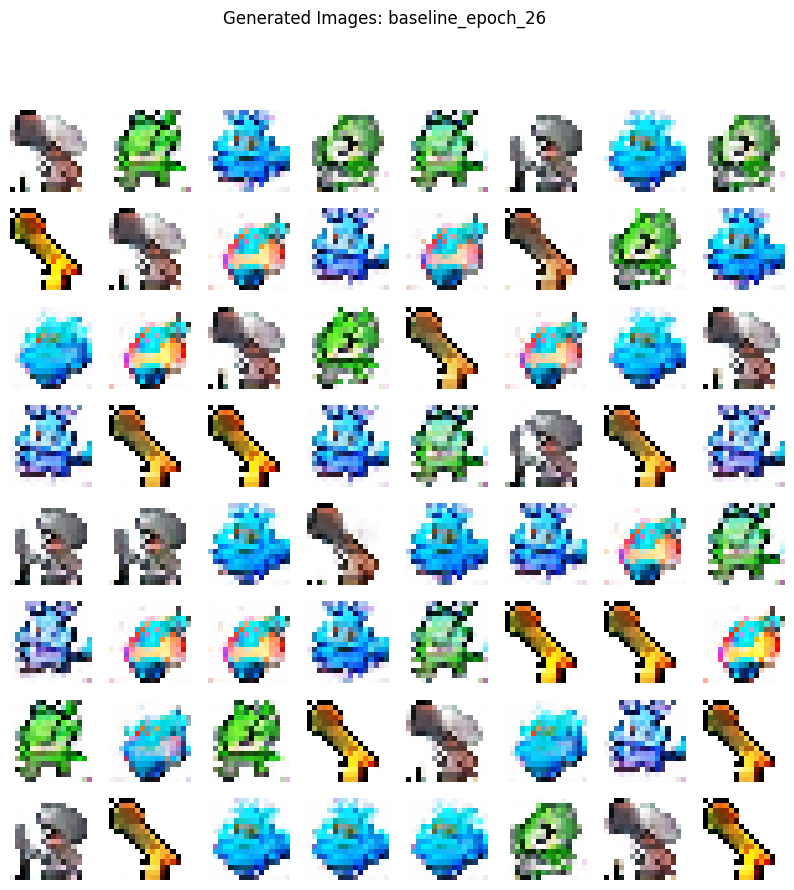

Epoch 27/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.79it/s, D_loss=0.2296, G_loss=3.4330]


Epoch [27/50] - D_loss: 0.2256, G_loss: 3.9935


Epoch 28/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.73it/s, D_loss=0.2022, G_loss=3.8837]


Epoch [28/50] - D_loss: 0.2177, G_loss: 4.1773


Epoch 29/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.71it/s, D_loss=0.2144, G_loss=3.5580]


Epoch [29/50] - D_loss: 0.2143, G_loss: 4.1877


Epoch 30/50: 100%|██████████| 1397/1397 [01:35<00:00, 14.67it/s, D_loss=0.2298, G_loss=3.6961]


Epoch [30/50] - D_loss: 0.2221, G_loss: 4.0678


Epoch 31/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.71it/s, D_loss=0.3101, G_loss=2.0986]


Epoch [31/50] - D_loss: 0.2146, G_loss: 4.1298


Epoch 32/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.73it/s, D_loss=0.1984, G_loss=4.2912]


Epoch [32/50] - D_loss: 0.2180, G_loss: 4.2176


Epoch 33/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.73it/s, D_loss=0.1964, G_loss=4.3555]


Epoch [33/50] - D_loss: 0.2189, G_loss: 4.1967


Epoch 34/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.74it/s, D_loss=0.2059, G_loss=4.5973]


Epoch [34/50] - D_loss: 0.2113, G_loss: 4.2762


Epoch 35/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.72it/s, D_loss=0.2060, G_loss=4.6181]


Epoch [35/50] - D_loss: 0.2087, G_loss: 4.3659


Epoch 36/50: 100%|██████████| 1397/1397 [01:35<00:00, 14.69it/s, D_loss=0.1824, G_loss=4.9516]


Epoch [36/50] - D_loss: 0.1975, G_loss: 4.6075


Epoch 37/50: 100%|██████████| 1397/1397 [01:35<00:00, 14.70it/s, D_loss=0.1849, G_loss=5.4419]


Epoch [37/50] - D_loss: 0.2014, G_loss: 4.6186


Epoch 38/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.71it/s, D_loss=0.1900, G_loss=4.8969]


Epoch [38/50] - D_loss: 0.2053, G_loss: 4.5420


Epoch 39/50: 100%|██████████| 1397/1397 [01:35<00:00, 14.69it/s, D_loss=0.2330, G_loss=4.5108]


Epoch [39/50] - D_loss: 0.2014, G_loss: 4.5437


Epoch 40/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.74it/s, D_loss=0.2101, G_loss=4.8044]


Epoch [40/50] - D_loss: 0.2024, G_loss: 4.6407


Epoch 41/50: 100%|██████████| 1397/1397 [01:35<00:00, 14.66it/s, D_loss=0.1901, G_loss=4.4915]


Epoch [41/50] - D_loss: 0.1951, G_loss: 4.7199


Epoch 42/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.72it/s, D_loss=0.1878, G_loss=5.3159]


Epoch [42/50] - D_loss: 0.1952, G_loss: 4.7830


Epoch 43/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.75it/s, D_loss=0.1831, G_loss=4.7220]


Epoch [43/50] - D_loss: 0.1974, G_loss: 4.7184


Epoch 44/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.71it/s, D_loss=0.2217, G_loss=3.7832]


Epoch [44/50] - D_loss: 0.1960, G_loss: 4.7671


Epoch 45/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.79it/s, D_loss=0.1971, G_loss=4.6094]


Epoch [45/50] - D_loss: 0.2090, G_loss: 4.3960


Epoch 46/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.74it/s, D_loss=0.1948, G_loss=4.8341]


Epoch [46/50] - D_loss: 0.2053, G_loss: 4.4745


Epoch 47/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.72it/s, D_loss=0.2181, G_loss=4.5038]


Epoch [47/50] - D_loss: 0.2067, G_loss: 4.4186


Epoch 48/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.77it/s, D_loss=0.2354, G_loss=5.2765]


Epoch [48/50] - D_loss: 0.2075, G_loss: 4.3639


Epoch 49/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.75it/s, D_loss=0.1892, G_loss=4.3919]


Epoch [49/50] - D_loss: 0.2070, G_loss: 4.3311


Epoch 50/50: 100%|██████████| 1397/1397 [01:34<00:00, 14.72it/s, D_loss=0.2030, G_loss=4.5169]


Epoch [50/50] - D_loss: 0.2014, G_loss: 4.5061


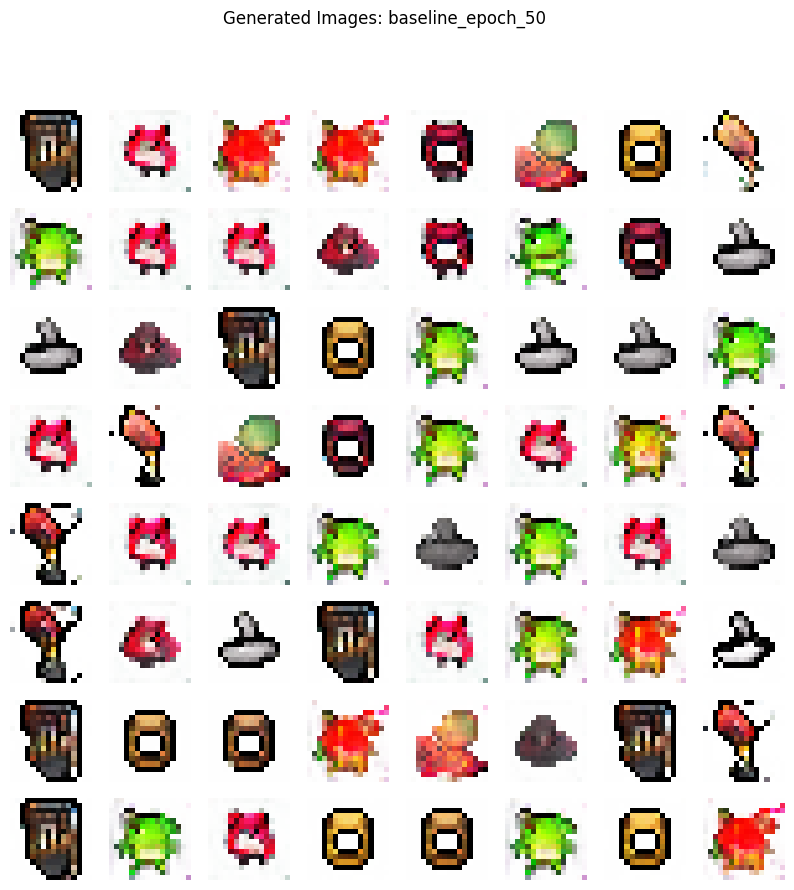

--- Entrenamiento Baseline Finalizado ---
--- Iniciando Entrenamiento: Configuración 2 (ADA + Dropout) ---


Epoch 1/50: 100%|██████████| 2794/2794 [01:46<00:00, 26.21it/s, D_loss=0.4559, G_loss=1.2507, p=0.010, rt=0.167]


Epoch [1/50] - D_loss: 0.4952, G_loss: 1.4080, p: 0.003


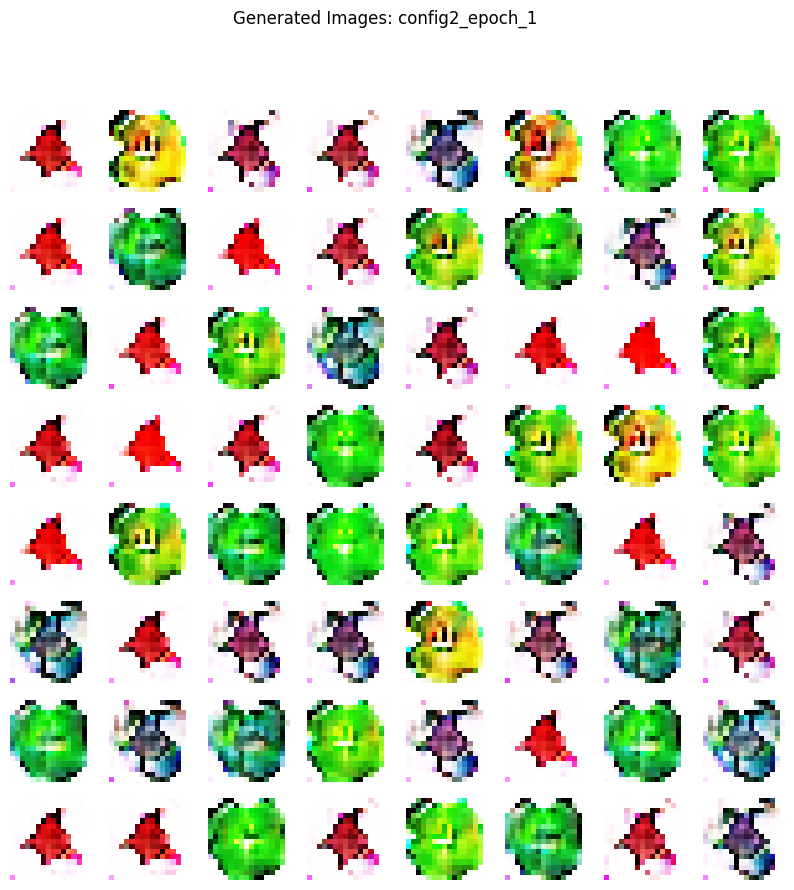

Epoch 2/50: 100%|██████████| 2794/2794 [01:45<00:00, 26.53it/s, D_loss=0.3511, G_loss=1.9843, p=0.010, rt=0.833]


Epoch [2/50] - D_loss: 0.3830, G_loss: 1.8152, p: 0.012


Epoch 3/50: 100%|██████████| 2794/2794 [01:54<00:00, 24.37it/s, D_loss=0.5160, G_loss=3.5676, p=0.750, rt=0.833]


Epoch [3/50] - D_loss: 0.3243, G_loss: 2.2223, p: 0.383


Epoch 4/50: 100%|██████████| 2794/2794 [02:08<00:00, 21.79it/s, D_loss=0.1670, G_loss=2.2432, p=0.800, rt=0.750]


Epoch [4/50] - D_loss: 0.3149, G_loss: 2.2999, p: 0.754


Epoch 5/50: 100%|██████████| 2794/2794 [02:08<00:00, 21.69it/s, D_loss=0.2481, G_loss=2.1755, p=0.800, rt=0.833]


Epoch [5/50] - D_loss: 0.3048, G_loss: 2.3367, p: 0.762


Epoch 6/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.63it/s, D_loss=0.4045, G_loss=1.9178, p=0.790, rt=0.250]


Epoch [6/50] - D_loss: 0.2933, G_loss: 2.3764, p: 0.788


Epoch 7/50: 100%|██████████| 2794/2794 [02:10<00:00, 21.47it/s, D_loss=0.1543, G_loss=2.4995, p=0.800, rt=0.750]


Epoch [7/50] - D_loss: 0.2741, G_loss: 2.3983, p: 0.795


Epoch 8/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.58it/s, D_loss=0.3028, G_loss=1.9753, p=0.800, rt=0.583]


Epoch [8/50] - D_loss: 0.2506, G_loss: 2.6064, p: 0.798


Epoch 9/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.58it/s, D_loss=0.2141, G_loss=2.2226, p=0.800, rt=0.750]


Epoch [9/50] - D_loss: 0.2371, G_loss: 2.6707, p: 0.798


Epoch 10/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.59it/s, D_loss=0.1392, G_loss=3.6778, p=0.800, rt=0.917]


Epoch [10/50] - D_loss: 0.2281, G_loss: 2.7521, p: 0.799


Epoch 11/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.62it/s, D_loss=0.1765, G_loss=4.5533, p=0.800, rt=1.000]


Epoch [11/50] - D_loss: 0.1892, G_loss: 3.0315, p: 0.800


Epoch 12/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.55it/s, D_loss=0.1911, G_loss=2.8059, p=0.800, rt=0.750]


Epoch [12/50] - D_loss: 0.1605, G_loss: 3.2590, p: 0.800


Epoch 13/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.63it/s, D_loss=0.0905, G_loss=3.6399, p=0.800, rt=0.917]


Epoch [13/50] - D_loss: 0.1414, G_loss: 3.4522, p: 0.800


Epoch 14/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.53it/s, D_loss=0.1485, G_loss=3.1571, p=0.800, rt=0.917]


Epoch [14/50] - D_loss: 0.1457, G_loss: 3.5819, p: 0.800


Epoch 15/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.59it/s, D_loss=0.2797, G_loss=2.9855, p=0.800, rt=0.833]


Epoch [15/50] - D_loss: 0.1621, G_loss: 3.4272, p: 0.800


Epoch 16/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.63it/s, D_loss=0.1857, G_loss=3.0746, p=0.800, rt=0.917]


Epoch [16/50] - D_loss: 0.1640, G_loss: 3.1555, p: 0.800


Epoch 17/50: 100%|██████████| 2794/2794 [02:10<00:00, 21.48it/s, D_loss=0.2439, G_loss=2.3022, p=0.800, rt=0.500]


Epoch [17/50] - D_loss: 0.1611, G_loss: 2.9430, p: 0.800


Epoch 18/50: 100%|██████████| 2794/2794 [02:10<00:00, 21.49it/s, D_loss=0.0413, G_loss=3.8728, p=0.800, rt=0.917]


Epoch [18/50] - D_loss: 0.1715, G_loss: 3.2736, p: 0.800


Epoch 19/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.54it/s, D_loss=0.4793, G_loss=1.0565, p=0.800, rt=0.083]


Epoch [19/50] - D_loss: 0.1512, G_loss: 3.6527, p: 0.800


Epoch 20/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.58it/s, D_loss=0.1059, G_loss=2.6725, p=0.800, rt=0.750]


Epoch [20/50] - D_loss: 0.1439, G_loss: 3.6169, p: 0.800


Epoch 21/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.57it/s, D_loss=0.1179, G_loss=4.1051, p=0.800, rt=0.917]


Epoch [21/50] - D_loss: 0.1399, G_loss: 3.6256, p: 0.800


Epoch 22/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.51it/s, D_loss=0.1850, G_loss=2.7359, p=0.800, rt=0.750]


Epoch [22/50] - D_loss: 0.1378, G_loss: 3.3299, p: 0.800


Epoch 23/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.57it/s, D_loss=0.0860, G_loss=3.7407, p=0.800, rt=0.917]


Epoch [23/50] - D_loss: 0.1206, G_loss: 3.4694, p: 0.800


Epoch 24/50: 100%|██████████| 2794/2794 [02:09<00:00, 21.51it/s, D_loss=0.1877, G_loss=2.9407, p=0.800, rt=0.750]


Epoch [24/50] - D_loss: 0.1124, G_loss: 3.9717, p: 0.800


Epoch 25/50: 100%|██████████| 2794/2794 [02:10<00:00, 21.36it/s, D_loss=0.0951, G_loss=5.4024, p=0.800, rt=1.000]


Epoch [25/50] - D_loss: 0.1230, G_loss: 3.8605, p: 0.800


Epoch 26/50: 100%|██████████| 2794/2794 [02:10<00:00, 21.42it/s, D_loss=0.0966, G_loss=4.1577, p=0.800, rt=1.000]


Epoch [26/50] - D_loss: 0.1309, G_loss: 3.9716, p: 0.800


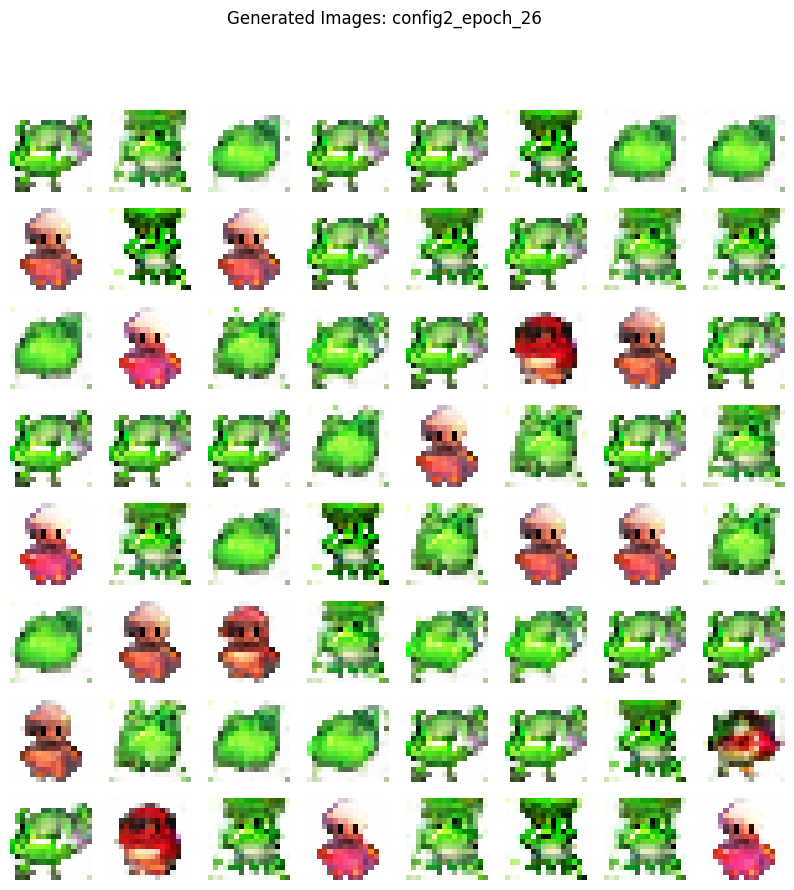

Epoch 27/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.11it/s, D_loss=0.0169, G_loss=5.8220, p=0.800, rt=1.000]


Epoch [27/50] - D_loss: 0.1256, G_loss: 4.0275, p: 0.800


Epoch 28/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.10it/s, D_loss=0.0219, G_loss=5.0070, p=0.800, rt=1.000]


Epoch [28/50] - D_loss: 0.1170, G_loss: 4.0069, p: 0.800


Epoch 29/50: 100%|██████████| 2794/2794 [02:11<00:00, 21.22it/s, D_loss=0.0620, G_loss=3.4836, p=0.800, rt=1.000]


Epoch [29/50] - D_loss: 0.1068, G_loss: 4.1521, p: 0.800


Epoch 30/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.10it/s, D_loss=0.0520, G_loss=4.4072, p=0.800, rt=1.000]


Epoch [30/50] - D_loss: 0.1070, G_loss: 4.2022, p: 0.800


Epoch 31/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.14it/s, D_loss=0.2081, G_loss=3.4199, p=0.800, rt=0.750]


Epoch [31/50] - D_loss: 0.0956, G_loss: 4.4693, p: 0.800


Epoch 32/50: 100%|██████████| 2794/2794 [02:11<00:00, 21.20it/s, D_loss=0.0916, G_loss=4.3792, p=0.800, rt=0.833]


Epoch [32/50] - D_loss: 0.1003, G_loss: 4.1351, p: 0.800


Epoch 33/50: 100%|██████████| 2794/2794 [02:11<00:00, 21.20it/s, D_loss=0.0552, G_loss=3.4536, p=0.800, rt=0.917]


Epoch [33/50] - D_loss: 0.0942, G_loss: 4.3047, p: 0.800


Epoch 34/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.08it/s, D_loss=0.0109, G_loss=6.0320, p=0.800, rt=1.000]


Epoch [34/50] - D_loss: 0.0946, G_loss: 4.5553, p: 0.800


Epoch 35/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.02it/s, D_loss=0.0706, G_loss=3.8860, p=0.800, rt=0.917]


Epoch [35/50] - D_loss: 0.0806, G_loss: 4.7149, p: 0.800


Epoch 36/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.07it/s, D_loss=0.1404, G_loss=2.6934, p=0.800, rt=0.750]


Epoch [36/50] - D_loss: 0.0697, G_loss: 5.1120, p: 0.800


Epoch 37/50: 100%|██████████| 2794/2794 [02:13<00:00, 20.99it/s, D_loss=0.0810, G_loss=4.5150, p=0.800, rt=0.833]


Epoch [37/50] - D_loss: 0.0662, G_loss: 5.0244, p: 0.800


Epoch 38/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.01it/s, D_loss=0.0434, G_loss=6.0365, p=0.800, rt=1.000]


Epoch [38/50] - D_loss: 0.0723, G_loss: 5.0802, p: 0.800


Epoch 39/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.06it/s, D_loss=0.1855, G_loss=4.7688, p=0.800, rt=0.917]


Epoch [39/50] - D_loss: 0.0797, G_loss: 4.9844, p: 0.800


Epoch 40/50: 100%|██████████| 2794/2794 [02:13<00:00, 20.93it/s, D_loss=0.0545, G_loss=3.8832, p=0.800, rt=0.917]


Epoch [40/50] - D_loss: 0.0791, G_loss: 4.9551, p: 0.800


Epoch 41/50: 100%|██████████| 2794/2794 [02:14<00:00, 20.77it/s, D_loss=0.0485, G_loss=3.8382, p=0.800, rt=0.917]


Epoch [41/50] - D_loss: 0.0694, G_loss: 4.8396, p: 0.800


Epoch 42/50: 100%|██████████| 2794/2794 [02:14<00:00, 20.81it/s, D_loss=0.0254, G_loss=6.9982, p=0.800, rt=1.000]


Epoch [42/50] - D_loss: 0.0655, G_loss: 5.4719, p: 0.800


Epoch 43/50: 100%|██████████| 2794/2794 [02:14<00:00, 20.73it/s, D_loss=0.1807, G_loss=6.1224, p=0.800, rt=0.833]


Epoch [43/50] - D_loss: 0.0714, G_loss: 5.3573, p: 0.800


Epoch 44/50: 100%|██████████| 2794/2794 [02:12<00:00, 21.10it/s, D_loss=0.1053, G_loss=4.8931, p=0.800, rt=0.917]


Epoch [44/50] - D_loss: 0.0635, G_loss: 5.3196, p: 0.800


Epoch 45/50: 100%|██████████| 2794/2794 [02:13<00:00, 20.96it/s, D_loss=0.1603, G_loss=5.5624, p=0.800, rt=0.917]


Epoch [45/50] - D_loss: 0.0626, G_loss: 5.7064, p: 0.800


Epoch 46/50: 100%|██████████| 2794/2794 [02:15<00:00, 20.66it/s, D_loss=0.0661, G_loss=5.2467, p=0.800, rt=0.917]


Epoch [46/50] - D_loss: 0.0766, G_loss: 5.4542, p: 0.800


Epoch 47/50: 100%|██████████| 2794/2794 [02:14<00:00, 20.70it/s, D_loss=0.1409, G_loss=6.9895, p=0.800, rt=0.917]


Epoch [47/50] - D_loss: 0.0697, G_loss: 5.5045, p: 0.800


Epoch 48/50: 100%|██████████| 2794/2794 [02:14<00:00, 20.82it/s, D_loss=0.0195, G_loss=6.9120, p=0.800, rt=1.000]


Epoch [48/50] - D_loss: 0.0641, G_loss: 5.6822, p: 0.800


Epoch 49/50: 100%|██████████| 2794/2794 [02:13<00:00, 20.86it/s, D_loss=0.0385, G_loss=8.0137, p=0.800, rt=1.000]


Epoch [49/50] - D_loss: 0.0578, G_loss: 5.7178, p: 0.800


Epoch 50/50: 100%|██████████| 2794/2794 [02:13<00:00, 20.93it/s, D_loss=0.0757, G_loss=5.2757, p=0.800, rt=0.833]


Epoch [50/50] - D_loss: 0.0554, G_loss: 5.6109, p: 0.800


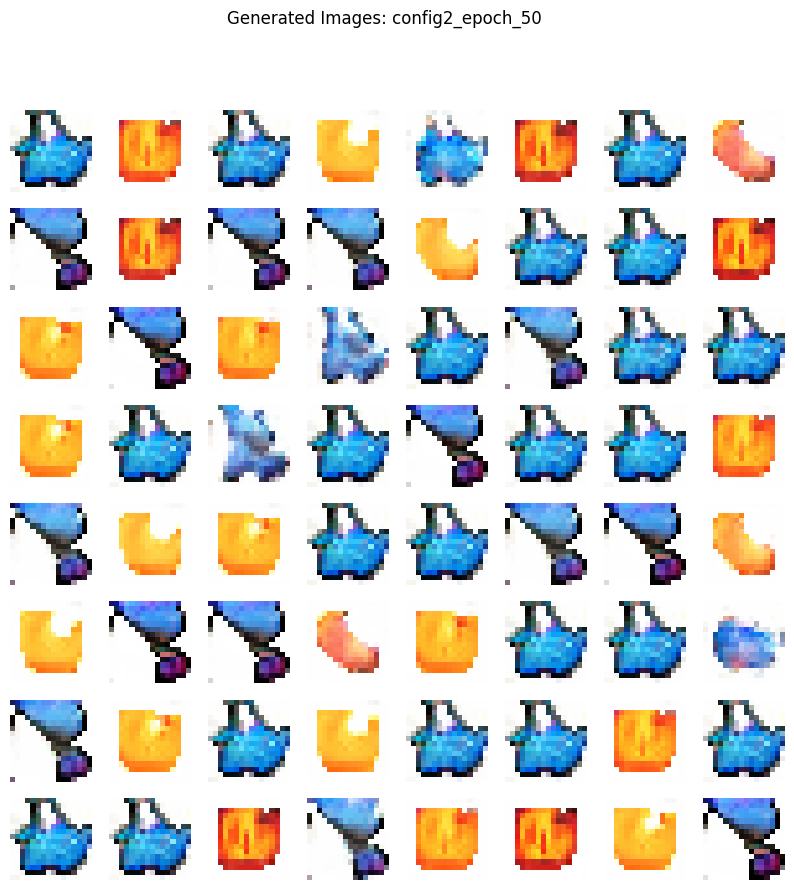

--- Entrenamiento Configuración 2 Finalizado ---
--- Iniciando Entrenamiento: Configuración 3 (Hinge Loss + ResNet-D + R1) ---


Epoch 1/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.14it/s, D_loss=1.2589, G_loss=0.2086, R1=0.00]


Epoch [1/50] - D_loss: 1.4502, G_loss: 0.8727


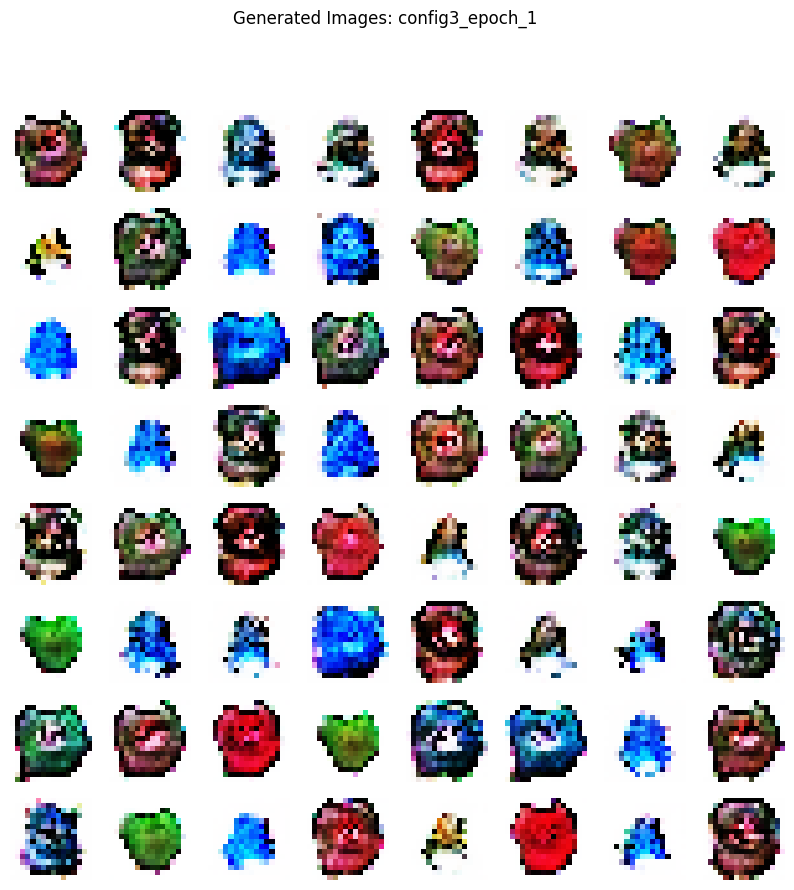

Epoch 2/50: 100%|██████████| 1397/1397 [01:27<00:00, 16.00it/s, D_loss=0.8770, G_loss=1.4792, R1=0.00]


Epoch [2/50] - D_loss: 1.1061, G_loss: 1.0551


Epoch 3/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.17it/s, D_loss=0.7877, G_loss=1.5113, R1=0.00]


Epoch [3/50] - D_loss: 0.9854, G_loss: 1.1558


Epoch 4/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.20it/s, D_loss=0.6765, G_loss=0.6431, R1=0.00]


Epoch [4/50] - D_loss: 0.8192, G_loss: 1.2832


Epoch 5/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.21it/s, D_loss=0.3073, G_loss=1.2885, R1=0.00]


Epoch [5/50] - D_loss: 0.6673, G_loss: 1.4110


Epoch 6/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.22it/s, D_loss=0.4609, G_loss=0.9449, R1=0.00]


Epoch [6/50] - D_loss: 0.5642, G_loss: 1.4741


Epoch 7/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.23it/s, D_loss=0.3051, G_loss=1.3315, R1=0.00]


Epoch [7/50] - D_loss: 0.4604, G_loss: 1.5447


Epoch 8/50: 100%|██████████| 1397/1397 [01:26<00:00, 16.19it/s, D_loss=0.2922, G_loss=1.9918, R1=0.00]


Epoch [8/50] - D_loss: 0.4022, G_loss: 1.5783


Epoch 9/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.32it/s, D_loss=0.0932, G_loss=1.3689, R1=0.00]


Epoch [9/50] - D_loss: 0.3679, G_loss: 1.6253


Epoch 10/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.27it/s, D_loss=0.1691, G_loss=1.2095, R1=0.00]


Epoch [10/50] - D_loss: 0.3331, G_loss: 1.6498


Epoch 11/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.30it/s, D_loss=0.0445, G_loss=1.5282, R1=0.00]


Epoch [11/50] - D_loss: 0.2722, G_loss: 1.6840


Epoch 12/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.30it/s, D_loss=0.0721, G_loss=1.4178, R1=0.00]


Epoch [12/50] - D_loss: 0.2569, G_loss: 1.6889


Epoch 13/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.28it/s, D_loss=0.1774, G_loss=1.5258, R1=0.00]


Epoch [13/50] - D_loss: 0.2374, G_loss: 1.6880


Epoch 14/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.30it/s, D_loss=0.1250, G_loss=2.1140, R1=0.00]


Epoch [14/50] - D_loss: 0.2492, G_loss: 1.6924


Epoch 15/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.34it/s, D_loss=0.1420, G_loss=1.2870, R1=0.00]


Epoch [15/50] - D_loss: 0.2195, G_loss: 1.7172


Epoch 16/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.29it/s, D_loss=0.0568, G_loss=1.6005, R1=0.00]


Epoch [16/50] - D_loss: 0.2196, G_loss: 1.7086


Epoch 17/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.39it/s, D_loss=0.0199, G_loss=1.6351, R1=0.00]


Epoch [17/50] - D_loss: 0.1981, G_loss: 1.7179


Epoch 18/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.44it/s, D_loss=0.1334, G_loss=1.7812, R1=0.00]


Epoch [18/50] - D_loss: 0.1911, G_loss: 1.7373


Epoch 19/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.44it/s, D_loss=0.0737, G_loss=2.2683, R1=0.00]


Epoch [19/50] - D_loss: 0.1744, G_loss: 1.7346


Epoch 20/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.44it/s, D_loss=0.2304, G_loss=2.2064, R1=0.00]


Epoch [20/50] - D_loss: 0.1718, G_loss: 1.7352


Epoch 21/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.46it/s, D_loss=0.1193, G_loss=1.3509, R1=0.00]


Epoch [21/50] - D_loss: 0.1924, G_loss: 1.7279


Epoch 22/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.44it/s, D_loss=0.1006, G_loss=1.4138, R1=0.00]


Epoch [22/50] - D_loss: 0.1815, G_loss: 1.7224


Epoch 23/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.49it/s, D_loss=0.1448, G_loss=1.5752, R1=0.00]


Epoch [23/50] - D_loss: 0.1667, G_loss: 1.7077


Epoch 24/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.38it/s, D_loss=0.0707, G_loss=1.6186, R1=0.00]


Epoch [24/50] - D_loss: 0.1573, G_loss: 1.7220


Epoch 25/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.40it/s, D_loss=0.0929, G_loss=1.5696, R1=0.00]


Epoch [25/50] - D_loss: 0.1672, G_loss: 1.7404


Epoch 26/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.44it/s, D_loss=0.0491, G_loss=1.7871, R1=0.00]


Epoch [26/50] - D_loss: 0.1777, G_loss: 1.6919


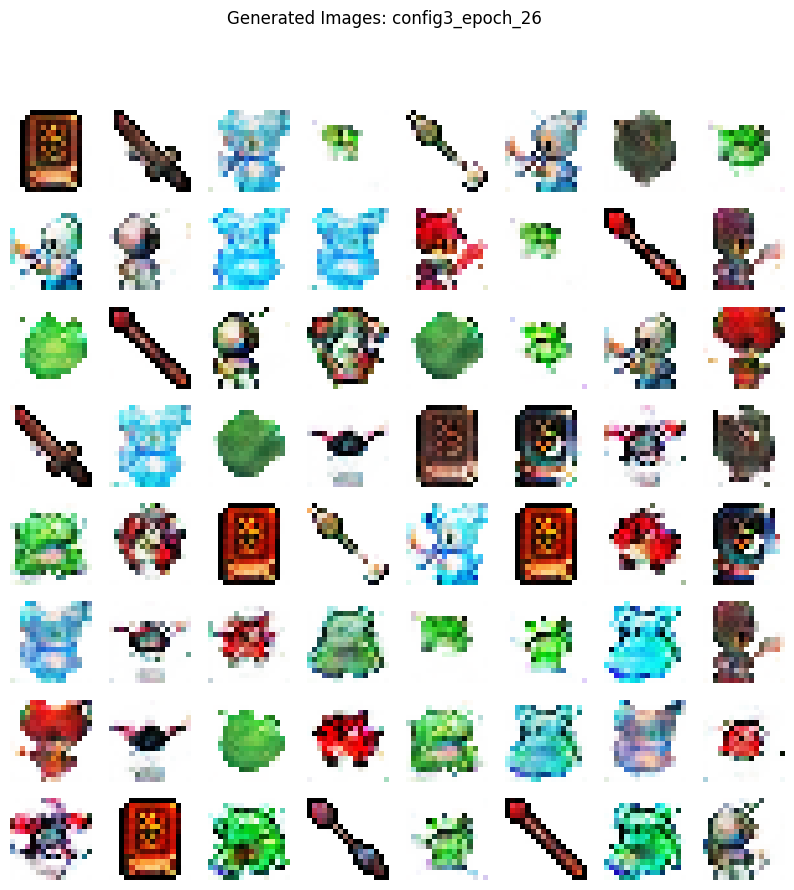

Epoch 27/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.35it/s, D_loss=0.0843, G_loss=1.9432, R1=0.00]


Epoch [27/50] - D_loss: 0.1840, G_loss: 1.7039


Epoch 28/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.37it/s, D_loss=0.0475, G_loss=1.6677, R1=0.00]


Epoch [28/50] - D_loss: 0.1791, G_loss: 1.7123


Epoch 29/50: 100%|██████████| 1397/1397 [01:25<00:00, 16.37it/s, D_loss=0.1351, G_loss=1.9088, R1=0.00]


Epoch [29/50] - D_loss: 0.1760, G_loss: 1.6810


Epoch 30/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.49it/s, D_loss=0.0939, G_loss=1.6572, R1=0.00]


Epoch [30/50] - D_loss: 0.1725, G_loss: 1.6856


Epoch 31/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.56it/s, D_loss=0.1064, G_loss=2.2481, R1=0.00]


Epoch [31/50] - D_loss: 0.1773, G_loss: 1.6928


Epoch 32/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.48it/s, D_loss=0.0146, G_loss=1.7208, R1=0.00]


Epoch [32/50] - D_loss: 0.1709, G_loss: 1.6838


Epoch 33/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.54it/s, D_loss=0.0955, G_loss=1.4932, R1=0.00]


Epoch [33/50] - D_loss: 0.1712, G_loss: 1.6760


Epoch 34/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.56it/s, D_loss=0.1221, G_loss=1.5423, R1=0.00]


Epoch [34/50] - D_loss: 0.1694, G_loss: 1.6904


Epoch 35/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.58it/s, D_loss=0.1824, G_loss=2.5319, R1=0.00]


Epoch [35/50] - D_loss: 0.1643, G_loss: 1.6713


Epoch 36/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.57it/s, D_loss=0.0450, G_loss=1.7381, R1=0.00]


Epoch [36/50] - D_loss: 0.1489, G_loss: 1.6790


Epoch 37/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.58it/s, D_loss=0.0809, G_loss=1.7593, R1=0.00]


Epoch [37/50] - D_loss: 0.1577, G_loss: 1.6844


Epoch 38/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.54it/s, D_loss=0.1348, G_loss=1.5194, R1=0.00]


Epoch [38/50] - D_loss: 0.1436, G_loss: 1.6755


Epoch 39/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.61it/s, D_loss=0.0694, G_loss=1.7483, R1=0.00]


Epoch [39/50] - D_loss: 0.1414, G_loss: 1.7341


Epoch 40/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.51it/s, D_loss=0.1063, G_loss=1.3451, R1=0.00]


Epoch [40/50] - D_loss: 0.1514, G_loss: 1.7170


Epoch 41/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.59it/s, D_loss=0.1532, G_loss=1.6773, R1=0.00]


Epoch [41/50] - D_loss: 0.1679, G_loss: 1.6922


Epoch 42/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.56it/s, D_loss=0.1398, G_loss=1.4654, R1=0.00]


Epoch [42/50] - D_loss: 0.1504, G_loss: 1.7039


Epoch 43/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.60it/s, D_loss=0.1664, G_loss=1.8679, R1=0.00]


Epoch [43/50] - D_loss: 0.1377, G_loss: 1.6923


Epoch 44/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.58it/s, D_loss=0.1908, G_loss=2.4543, R1=0.00]


Epoch [44/50] - D_loss: 0.1408, G_loss: 1.7253


Epoch 45/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.58it/s, D_loss=0.0454, G_loss=1.6566, R1=0.00]


Epoch [45/50] - D_loss: 0.1462, G_loss: 1.7186


Epoch 46/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.51it/s, D_loss=0.1158, G_loss=1.8653, R1=0.00]


Epoch [46/50] - D_loss: 0.1373, G_loss: 1.7115


Epoch 47/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.51it/s, D_loss=0.0180, G_loss=1.7798, R1=0.00]


Epoch [47/50] - D_loss: 0.1387, G_loss: 1.7103


Epoch 48/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.55it/s, D_loss=0.1195, G_loss=1.3869, R1=0.00]


Epoch [48/50] - D_loss: 0.1519, G_loss: 1.7029


Epoch 49/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.60it/s, D_loss=0.0669, G_loss=1.7157, R1=0.00]


Epoch [49/50] - D_loss: 0.1661, G_loss: 1.6705


Epoch 50/50: 100%|██████████| 1397/1397 [01:24<00:00, 16.48it/s, D_loss=0.0694, G_loss=1.5823, R1=0.00]


Epoch [50/50] - D_loss: 0.1760, G_loss: 1.6621


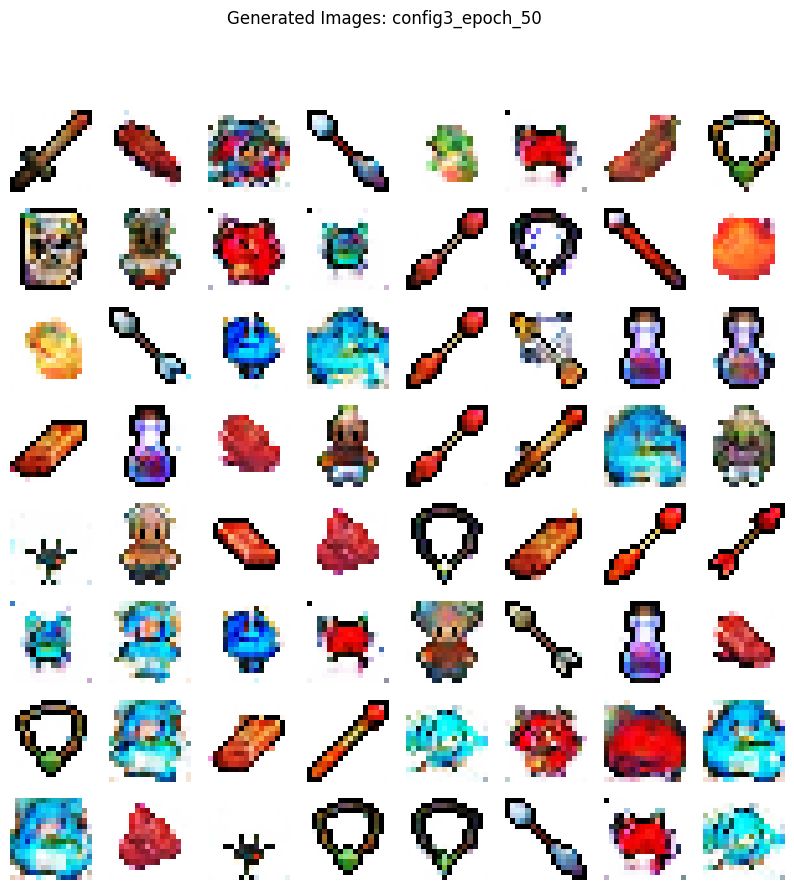

--- Entrenamiento Configuración 3 Finalizado ---


In [13]:
BASELINE_CONFIG = {
    'batch_size': 64,
    'lr_g': 0.002,
    'lr_d': 0.002,
    'beta1': 0.0,
    'beta2': 0.999,
    'num_epochs': 50, # Reducido para ejecución más rápida en el entorno de prueba
    'latent_dim': 256,
    'sample_interval': 10
}

dataloader_baseline = DataLoader(dataset, batch_size=BASELINE_CONFIG['batch_size'], shuffle=True, num_workers=2)

g_base, d_base, losses_base = train_baseline(BASELINE_CONFIG, dataloader_baseline)

results = {
    'baseline': {
        'generator': g_base,
        'discriminator': d_base,
        'losses': losses_base,
        'metrics': {},
        'config': BASELINE_CONFIG
    }
}

CONFIG_2 = {
    'batch_size': 32,
    'lr_g': 0.0015,
    'lr_d': 0.002,
    'beta1': 0.0,
    'beta2': 0.999,
    'num_epochs': 50,
    'latent_dim': 256,
    'sample_interval': 10,
    'dropout_rate': 0.25
}

dataloader_config2 = DataLoader(dataset, batch_size=CONFIG_2['batch_size'], shuffle=True, num_workers=2)
g_ada, d_ada, losses_ada = train_config_2(CONFIG_2, dataloader_config2)

results['config2_ada'] = {
    'generator': g_ada,
    'discriminator': d_ada,
    'losses': losses_ada,
    'metrics': {},
    'config': CONFIG_2
}

CONFIG_3 = {
    'batch_size': 64,
    'lr_g': 0.002,
    'lr_d': 0.002,
    'beta1': 0.0,
    'beta2': 0.999,
    'num_epochs': 50,
    'latent_dim': 128, # Reduced latent dimension
    'sample_interval': 10,
    'r1_interval': 16,
    'r1_gamma': 10.0
}

dataloader_config3 = DataLoader(dataset, batch_size=CONFIG_3['batch_size'], shuffle=True, num_workers=2)
g_res, d_res, losses_res = train_config_3(CONFIG_3, dataloader_config3)

results['config3_resnet'] = {
    'generator': g_res,
    'discriminator': d_res,
    'losses': losses_res,
    'metrics': {},
    'config': CONFIG_3
}

## 5. Evaluación

Cálculo de métricas (FID, IS) y visualización comparativa de los resultados.

In [15]:
import os
import tempfile
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics

# Configuración
CALCULATE_METRICS = True
DATA_PATH = '/kaggle/input/pixel-art/sprites.npy'
REAL_IMAGES_DIR = 'results/real_images'  # Directorio con imágenes reales

def calculate_and_store_metrics(generator, name, config, results_dict, real_images_dir):
    """Calcula métricas FID e IS para un generador"""
    print(f'--- Calculating FID/IS for {name} ---')
    generator.eval()

    with tempfile.TemporaryDirectory() as temp_dir:
        num_samples = 5000
        batch_size = 64

        # Generar imágenes
        with torch.no_grad():
            for i in range(0, num_samples, batch_size):
                current_batch = min(batch_size, num_samples - i)
                z = torch.randn(current_batch, config['latent_dim'], device=device)
                images = generator(z)
                images = (images + 1) / 2  # Desnormalizar

                for j in range(current_batch):
                    img_path = os.path.join(temp_dir, f'image_{i+j:05d}.png')
                    save_image(images[j], img_path)

        print(f"Generated {num_samples} images for {name}")

        try:
            metrics = calculate_metrics(
                input1=temp_dir,
                input2=real_images_dir,  # Directorio con imágenes reales
                fid=True,
                isc=True,
                verbose=True,
                save_cpu_ram=True
            )

            fid_score = metrics['frechet_inception_distance']
            is_mean = metrics['inception_score_mean']
            is_std = metrics['inception_score_std']

        except Exception as e:
            print(f"Error calculating metrics for {name}: {e}")
            fid_score, is_mean, is_std = float('inf'), 0.0, 0.0

    results_dict[name]['metrics'] = {
        'fid': fid_score,
        'is_mean': is_mean,
        'is_std': is_std
    }

    generator.train()
    return fid_score, is_mean, is_std

class UnnormalizedPixelArtDataset(Dataset):
    def __init__(self, data_path):
        self.sprites = np.load(data_path)
        print(f"Loaded {len(self.sprites)} real images")

    def __len__(self):
        return len(self.sprites)

    def __getitem__(self, idx):
        image = self.sprites[idx]
        image_tensor = torch.from_numpy(image).float()
        if image_tensor.dim() == 3 and image_tensor.shape[2] == 3:
            image_tensor = image_tensor.permute(2, 0, 1)
        return image_tensor

# Crear directorio para resultados
os.makedirs(REAL_IMAGES_DIR, exist_ok=True)

# Guardar imágenes reales
if not os.listdir(REAL_IMAGES_DIR):  # Si está vacío
    print("Saving real dataset images...")

    dataset = UnnormalizedPixelArtDataset(DATA_PATH)
    subset_indices = np.random.choice(len(dataset), min(5000, len(dataset)), replace=False)
    subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

    print(f"Using {len(subset_indices)} real images")

    # Guardar imágenes reales
    for i, (image, ) in enumerate(DataLoader(subset_dataset, batch_size=1)):
        img_path = os.path.join(REAL_IMAGES_DIR, f'real_{i:05d}.png')
        save_image(image[0], img_path)

    print(f"Real images saved to {REAL_IMAGES_DIR}")
else:
    print(f"Real images already exist in {REAL_IMAGES_DIR}")

# Calcular métricas para generadores
if CALCULATE_METRICS:
    print("\n" + "="*50)
    print("CALCULATING METRICS FOR TRAINED GENERATORS")
    print("="*50)

    for name in results.keys():
        if 'metrics' not in results[name]:
            results[name]['metrics'] = {}

    for name, data in results.items():
        if 'generator' in data and data['generator'] is not None:
            calculate_and_store_metrics(
                data['generator'], name, data['config'], results, REAL_IMAGES_DIR
            )
        else:
            print(f"Skipping {name} - no generator found")

    print("\n" + "="*50)
    print("FINAL METRICS RESULTS:")
    print("="*50)
    for name, data in results.items():
        if 'metrics' in data:
            m = data['metrics']
            print(f"{name}:")
            print(f"  FID: {m.get('fid', 'N/A'):.2f}")
            print(f"  IS: {m.get('is_mean', 'N/A'):.2f} ± {m.get('is_std', 'N/A'):.2f}")
else:
    print("Metric calculation disabled")

Saving real dataset images...
Loaded 89400 real images
Using 5000 real images
Real images saved to results/real_images

CALCULATING METRICS FOR TRAINED GENERATORS
--- Calculating FID/IS for baseline ---
Generated 5000 images for baseline


Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/tmp_jpnzl_x" with extensions png,jpg,jpeg
Found 5000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "results/real_images" with extensions png,jpg,jpeg
Found 5000 samples
Processing samples
Inception Score: 2.422224606614873 ± 0.04084629813968623
Frechet Inception Distance: 315.5766060934659


--- Calculating FID/IS for config2_ada ---
Generated 5000 images for config2_ada


Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/tmp7wh7ja07" with extensions png,jpg,jpeg
Found 5000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "results/real_images" with extensions png,jpg,jpeg
Found 5000 samples
Processing samples
Inception Score: 2.2083189483389414 ± 0.024692715685892805
Frechet Inception Distance: 341.80200605957947


--- Calculating FID/IS for config3_resnet ---
Generated 5000 images for config3_resnet


Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/tmp562w9jtb" with extensions png,jpg,jpeg
Found 5000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "results/real_images" with extensions png,jpg,jpeg
Found 5000 samples
Processing samples
Inception Score: 3.697417397669324 ± 0.0758603989458422



FINAL METRICS RESULTS:
baseline:
  FID: 315.58
  IS: 2.42 ± 0.04
config2_ada:
  FID: 341.80
  IS: 2.21 ± 0.02
config3_resnet:
  FID: 310.69
  IS: 3.70 ± 0.08


Frechet Inception Distance: 310.6871143487016


### Tabla Resumen de Métricas

In [16]:
if CALCULATE_METRICS:
    summary_data = []
    for name, data in results.items():
        summary_data.append({
            'Configuration': name,
            'Final G Loss': f"{data['losses']['G'][-1]:.4f}",
            'Final D Loss': f"{data['losses']['D'][-1]:.4f}",
            'FID': f"{data['metrics'].get('fid', 'N/A'):.2f}",
            'Inception Score': f"{data['metrics'].get('is_mean', 'N/A'):.2f} ± {data['metrics'].get('is_std', 'N/A'):.2f}"
        })

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('results/metrics_summary.csv', index=False)

    print("Tabla de Resumen de Métricas:")
    display(summary_df)

Tabla de Resumen de Métricas:


,Configuration,Final G Loss,Final D Loss,FID,Inception Score
0,baseline,4.5061,0.2014,315.58,2.42 ± 0.04
1,config2_ada,5.6109,0.0554,341.80,2.21 ± 0.02
2,config3_resnet,1.6621,0.1760,310.69,3.70 ± 0.08


### Gráficos de Métricas y Pérdidas

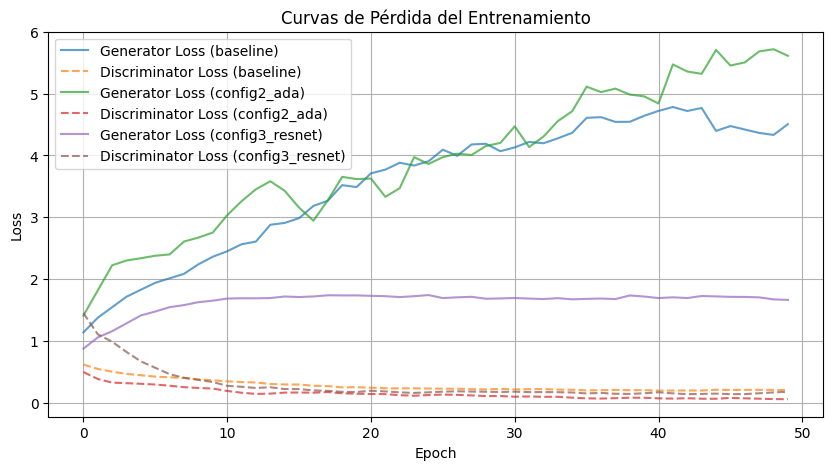

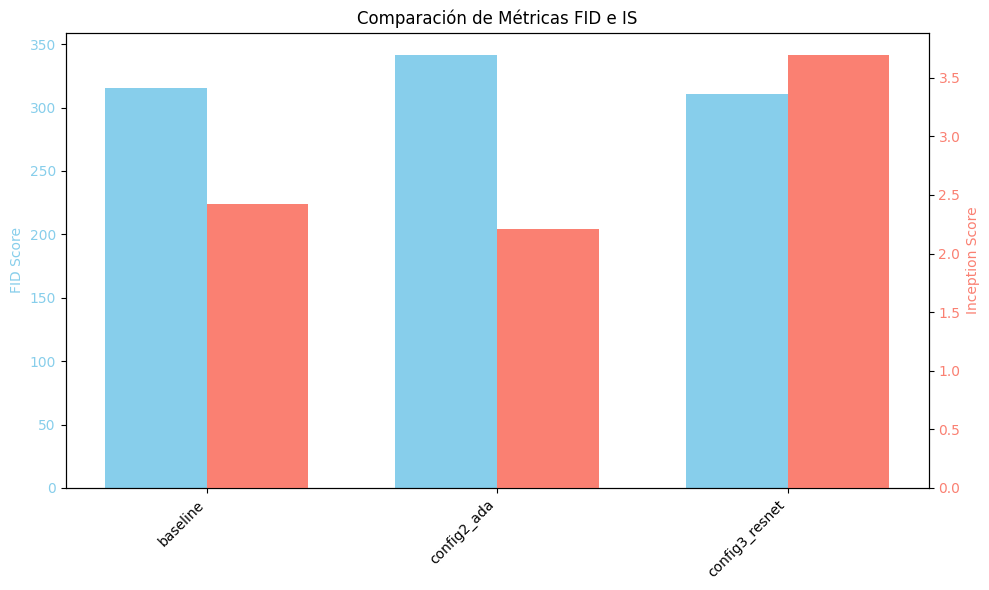

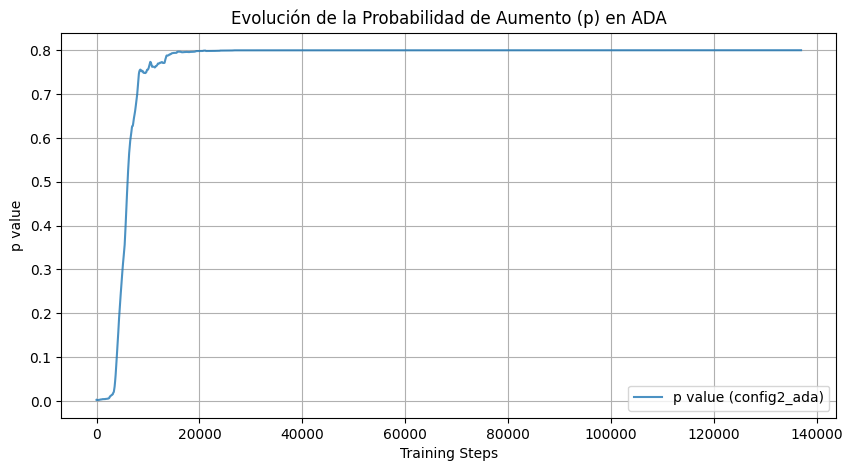

In [17]:
def plot_metrics(results):
    names = list(results.keys())
    fid_scores = [data['metrics'].get('fid', 0) for data in results.values()]
    is_scores = [data['metrics'].get('is_mean', 0) for data in results.values()]

    x = np.arange(len(names))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(x - width/2, fid_scores, width, label='FID (lower is better)', color='skyblue')
    ax1.set_ylabel('FID Score', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.set_title('Comparación de Métricas FID e IS')

    ax2 = ax1.twinx()
    ax2.bar(x + width/2, is_scores, width, label='IS (higher is better)', color='salmon')
    ax2.set_ylabel('Inception Score', color='salmon')
    ax2.tick_params(axis='y', labelcolor='salmon')

    fig.tight_layout()
    plt.savefig('results/metrics_comparison.png')
    plt.show()

def plot_losses(results):
    plt.figure(figsize=(10, 5))
    for name, data in results.items():
        plt.plot(data['losses']['G'], label=f'Generator Loss ({name})', alpha=0.7)
        plt.plot(data['losses']['D'], label=f'Discriminator Loss ({name})', linestyle='--', alpha=0.7)
    plt.title('Curvas de Pérdida del Entrenamiento')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('results/loss_curves.png')
    plt.show()

def plot_p_history(results):
    plt.figure(figsize=(10, 5))
    for name, data in results.items():
        if 'p' in data['losses']:
            p_history = data['losses']['p']
            window_size = len(p_history) // data['config']['num_epochs']
            if window_size > 0:
                smoothed_p = np.convolve(p_history, np.ones(window_size)/window_size, mode='valid')
                plt.plot(smoothed_p, label=f'p value ({name})', alpha=0.8)
    plt.title('Evolución de la Probabilidad de Aumento (p) en ADA')
    plt.xlabel('Training Steps')
    plt.ylabel('p value')
    plt.legend()
    plt.grid(True)
    plt.savefig('results/p_history.png')
    plt.show()

plot_losses(results)
if CALCULATE_METRICS:
    plot_metrics(results)
    plot_p_history(results)

## 6. Inferencia de ejemplo

Generación de imágenes de muestra con los modelos entrenados.

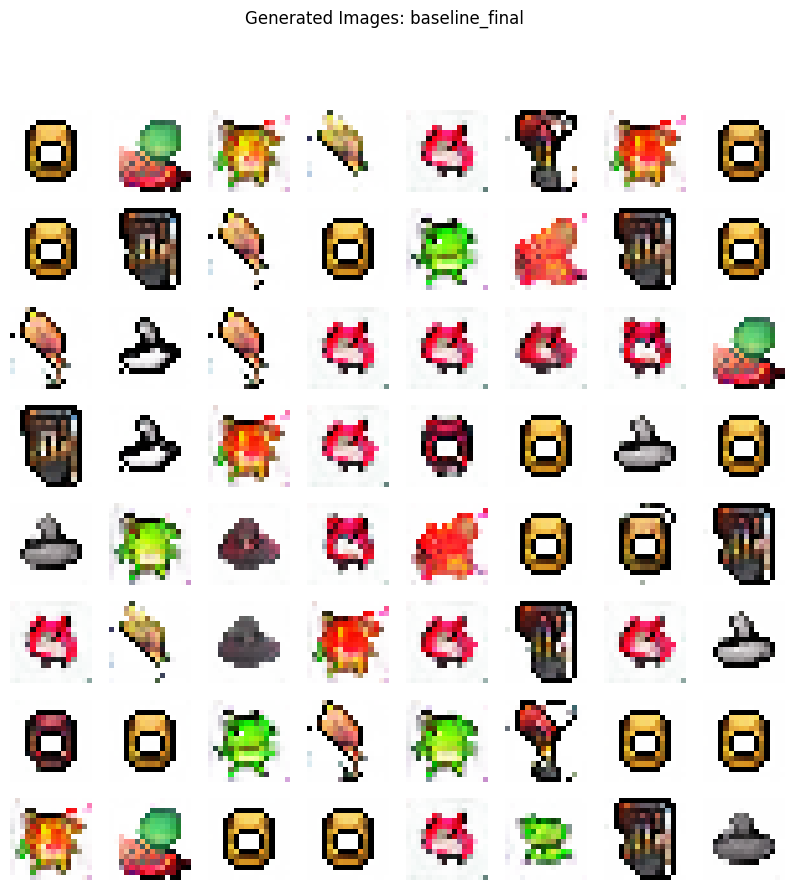

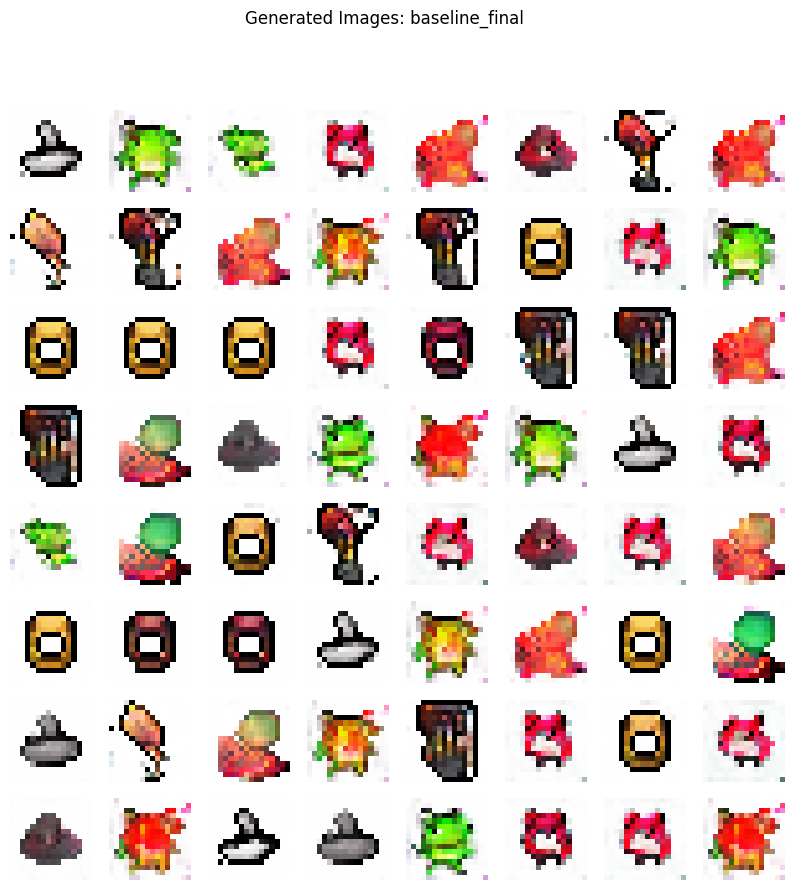

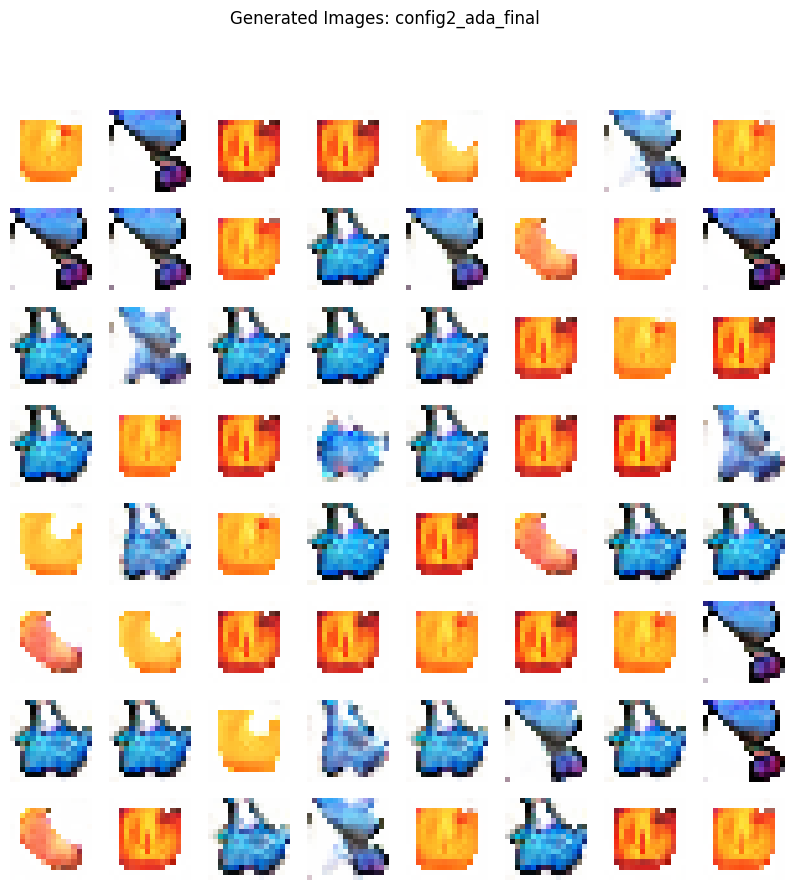

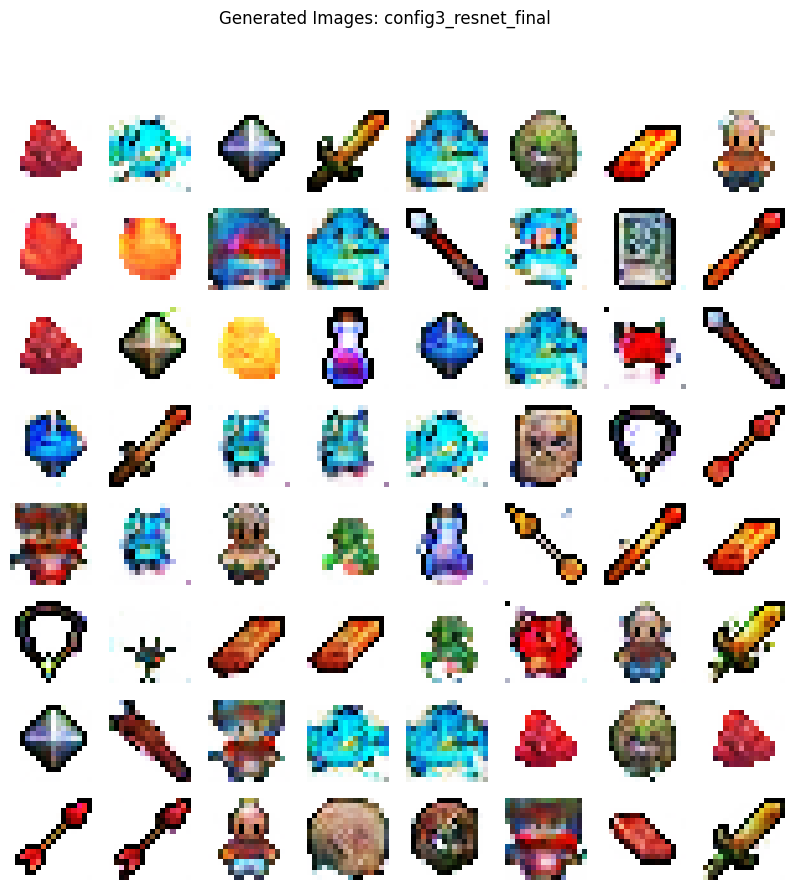

In [19]:
fixed_z_inference = torch.randn(64, BASELINE_CONFIG['latent_dim'], device=device)
save_samples(g_base, 'baseline_final', fixed_z_inference)

# Save final samples for all configurations
for name, data in results.items():
    fixed_z = torch.randn(64, data['config']['latent_dim'], device=device)
    save_samples(data['generator'], f"{name}_final", fixed_z)

### Comparación con Imágenes Reales

--- Finding most similar real images for baseline ---


Comparing images: 100%|██████████| 8/8 [00:00<00:00, 210.53it/s]


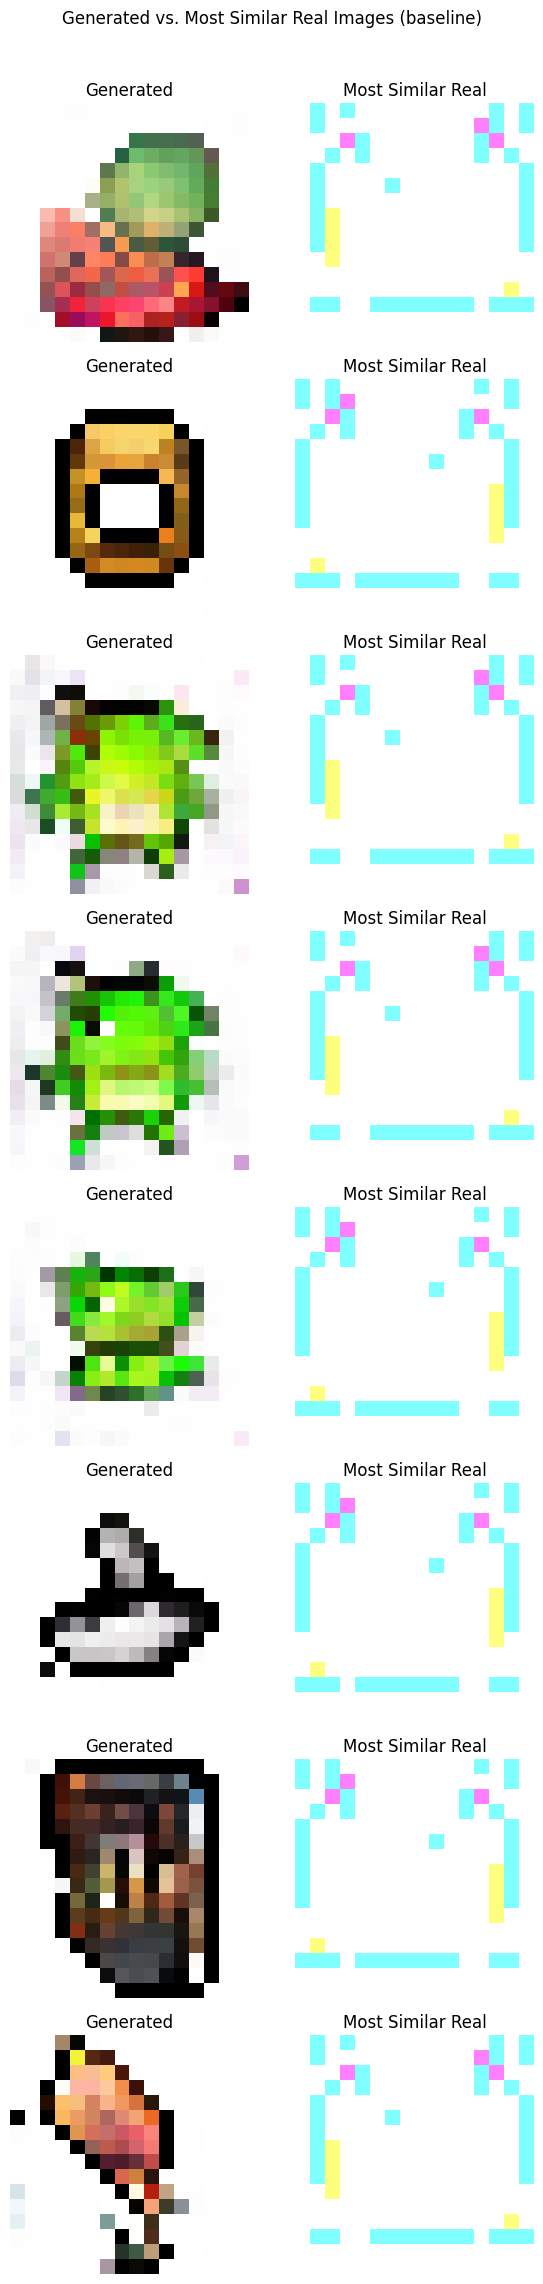

--- Finding most similar real images for config2_ada ---


Comparing images: 100%|██████████| 8/8 [00:00<00:00, 3417.99it/s]


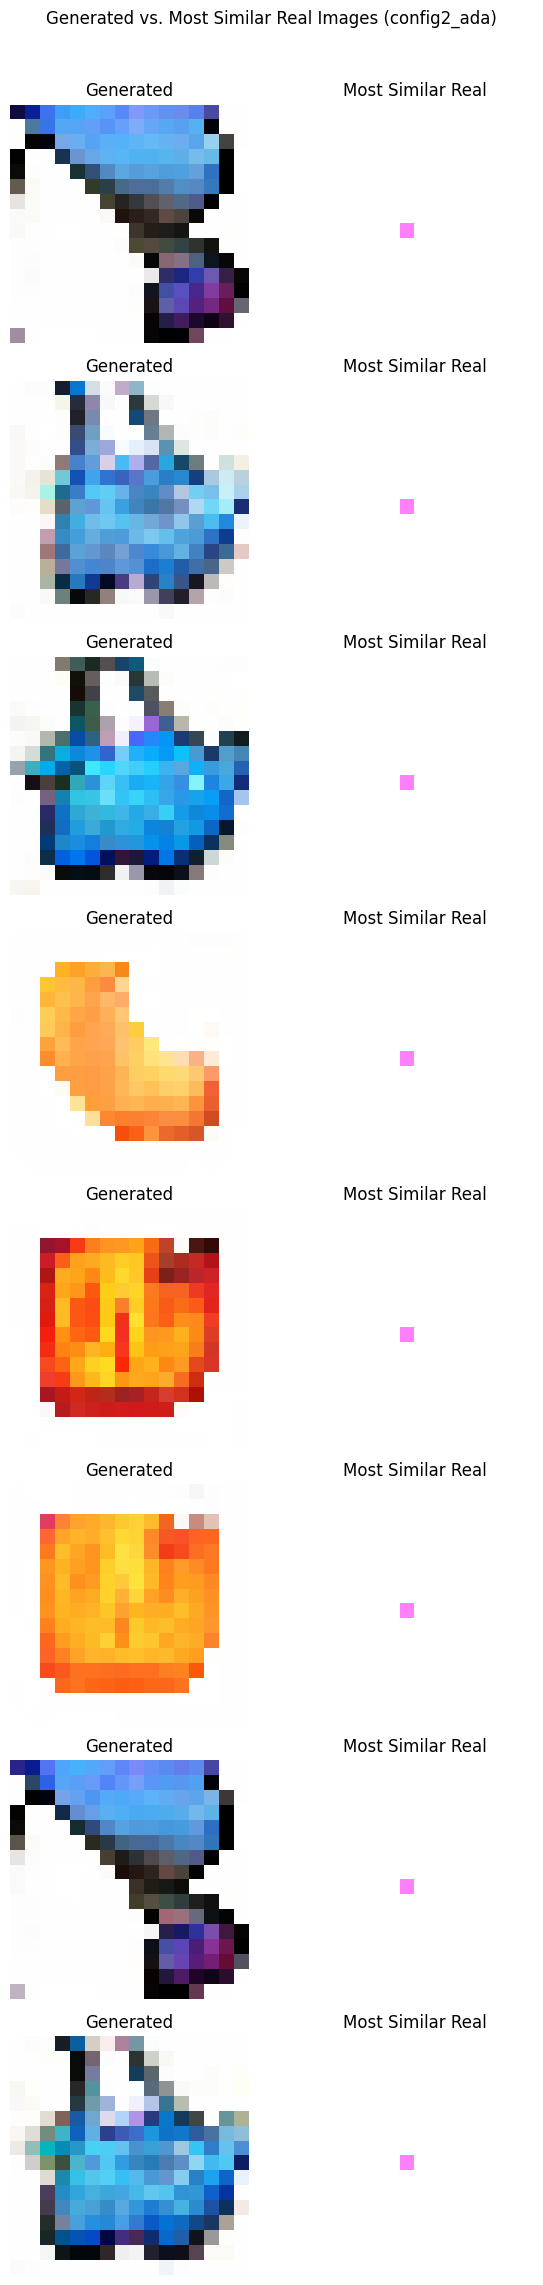

--- Finding most similar real images for config3_resnet ---


Comparing images: 100%|██████████| 8/8 [00:00<00:00, 2397.43it/s]


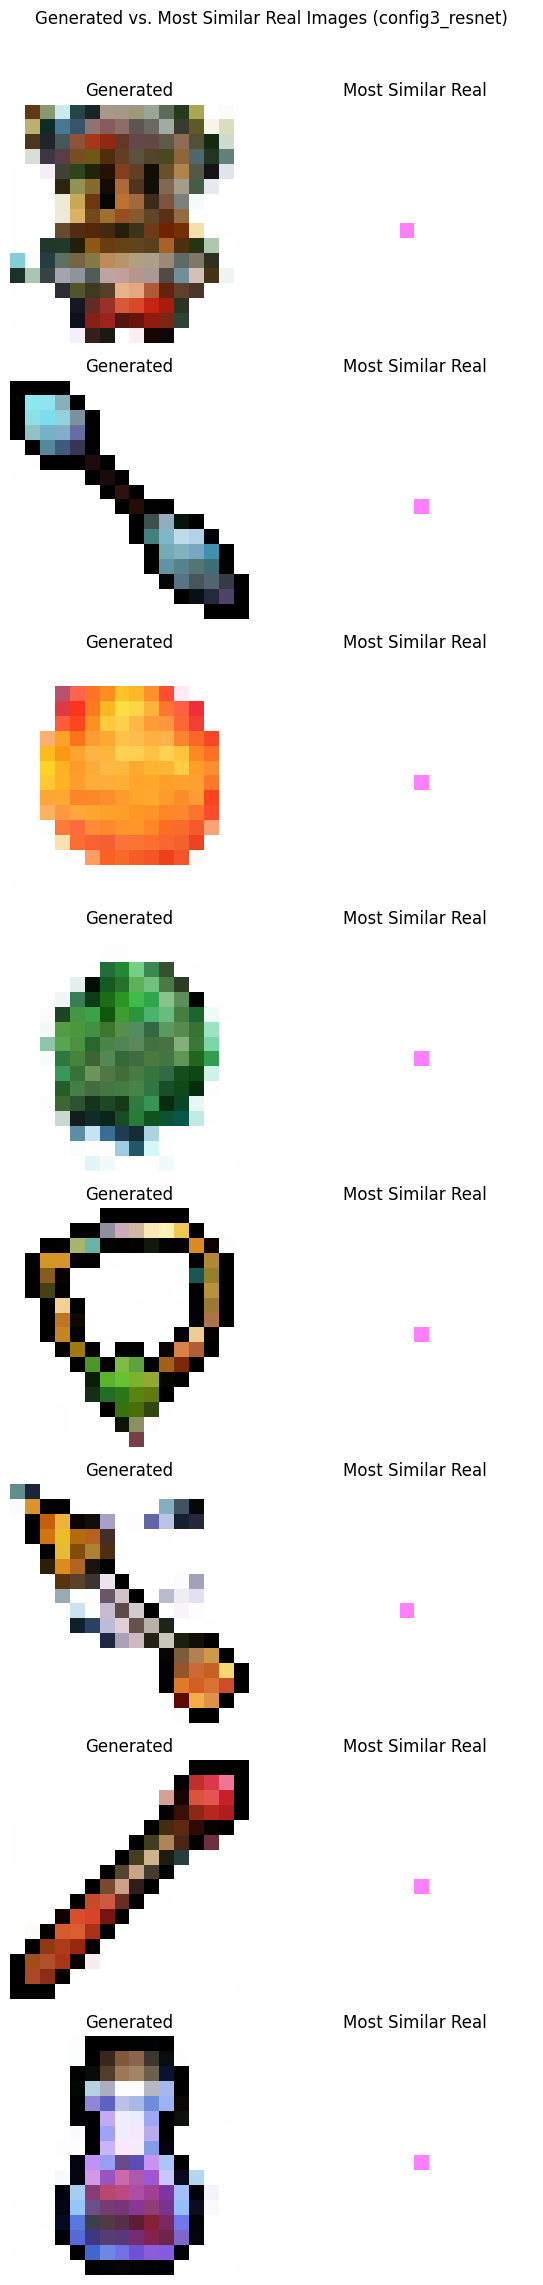

In [20]:
def find_most_similar_real_images(generator, name, config, dataset, num_fakes=8, num_real_to_check=2000):
    print(f'--- Finding most similar real images for {name} ---')
    generator.eval()

    # Generate fake images
    z = torch.randn(num_fakes, config['latent_dim'], device=device)
    with torch.no_grad():
        fake_images = generator(z)

    # Prepare real images
    real_subset_indices = np.random.choice(len(dataset), num_real_to_check, replace=False)
    real_images_to_check = torch.stack([dataset[i] for i in real_subset_indices]).to(device)

    similar_pairs = []
    for i in tqdm(range(num_fakes), desc="Comparing images"):
        fake_img = fake_images[i]
        distances = torch.abs(real_images_to_check - fake_img).mean(dim=[1, 2, 3])
        best_match_idx = torch.argmin(distances)
        similar_pairs.append((fake_img.cpu(), real_images_to_check[best_match_idx].cpu()))

    # Plot the pairs
    fig, axes = plt.subplots(num_fakes, 2, figsize=(6, num_fakes * 3))
    if num_fakes == 1:
        axes = [axes]
    for i, (fake_img, real_img) in enumerate(similar_pairs):
        axes[i, 0].imshow(denormalize(fake_img).permute(1, 2, 0))
        axes[i, 0].set_title("Generated")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(denormalize(real_img).permute(1, 2, 0))
        axes[i, 1].set_title("Most Similar Real")
        axes[i, 1].axis('off')

    plt.suptitle(f'Generated vs. Most Similar Real Images ({name})')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    os.makedirs('results/inference', exist_ok=True)
    plt.savefig(f"results/inference/similar_comparison_{name}.png")
    plt.show()

    generator.train()

# Run the comparison for all trained models
for name, data in results.items():
    find_most_similar_real_images(data['generator'], name, data['config'], dataset)

## 7. Guardado de resultados

Guardado de los modelos finales y los resultados de las métricas.

In [21]:
def save_model(generator, name):
    os.makedirs('results/models', exist_ok=True)
    torch.save(generator.state_dict(), f'results/models/generator_{name}.pth')

save_model(g_base, 'baseline')
print("Modelos guardados en 'results/models'.")

Modelos guardados en 'results/models'.


In [22]:
import shutil
import os

# Comprimir las carpetas checkpoints y results
shutil.make_archive('results_and_checkpoints', 'zip', '.', 'checkpoints')
shutil.make_archive('results_and_checkpoints', 'zip', '.', 'results')

print("Carpetas 'checkpoints' y 'results' comprimidas en 'results_and_checkpoints.zip'")

Carpetas 'checkpoints' y 'results' comprimidas en 'results_and_checkpoints.zip'
